In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import os
import cv2
from PIL import Image
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, \
    BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from skimage import filters
from scipy.stats import boxcox

In [2]:
data_dir = 'agriculture-crops'
df = pd.read_csv('mbajk_dataset.csv')

In [3]:
df.shape

(18692, 11)

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.isnull().sum()

date                            0
temperature                  1869
relative_humidity               0
dew_point                       0
apparent_temperature            0
precipitation_probability    1308
rain                         2804
surface_pressure                0
bike_stands                     0
available_bike_stands           0
dtype: int64

In [5]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.0,0.0,984.3,22,8
1,2023-06-25 20:25:41+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8
2,2023-06-25 20:12:20+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,12
3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,7
4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8


In [6]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

#dodana prva dodatna značilnica, da lahko potem odstarnim datum
df['weekend'] = np.where(df['date'].dt.dayofweek > 4, 1, 0)
df.drop('date', axis=1, inplace=True)

In [7]:
input_data = df.columns.tolist()
output_data = ['temperature', 'precipitation_probability', 'rain']
for i in output_data: input_data.remove(i)

for column in output_data:
    # izbereš vrstice manjkajočih vrednosti
    test_data = df[df[column].isnull()]
    # kopija za obdelavo
    df_copy = df.copy()
    df_copy.dropna(subset=[column], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df_copy[input_data], df_copy[column], test_size=0.30)
    reg = LinearRegression().fit(X_train, y_train)
    pred = reg.predict(test_data[input_data])
    # lociras vrstice in jih zapolnis z napovedanimi vrednostmi
    df.loc[test_data.index, column] = pred
    
df.isnull().sum()

temperature                  0
relative_humidity            0
dew_point                    0
apparent_temperature         0
precipitation_probability    0
rain                         0
surface_pressure             0
bike_stands                  0
available_bike_stands        0
year                         0
month                        0
day                          0
hour                         0
weekend                      0
dtype: int64

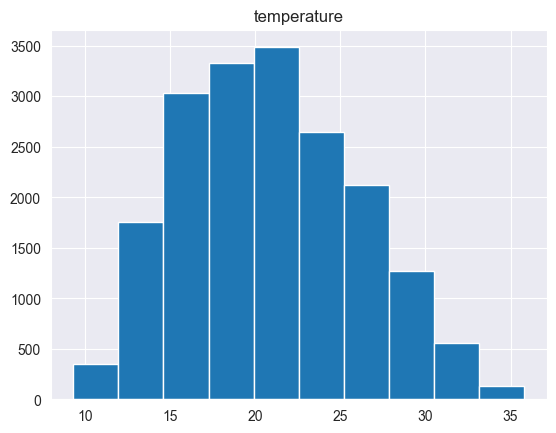

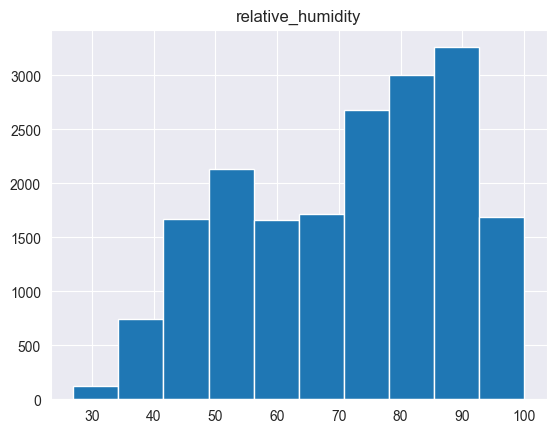

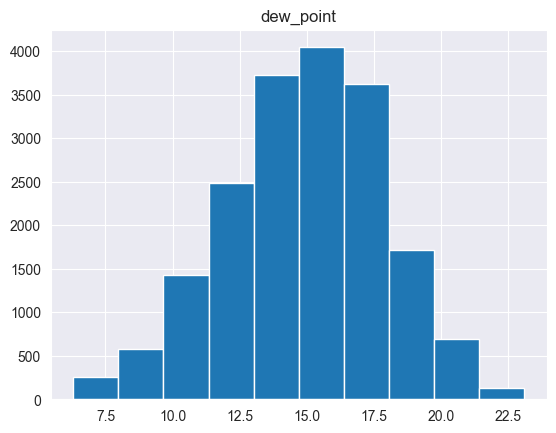

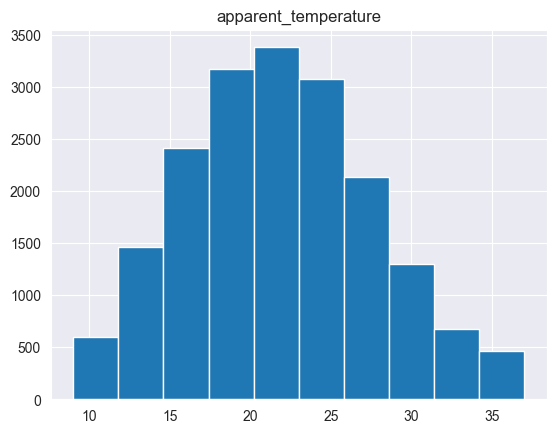

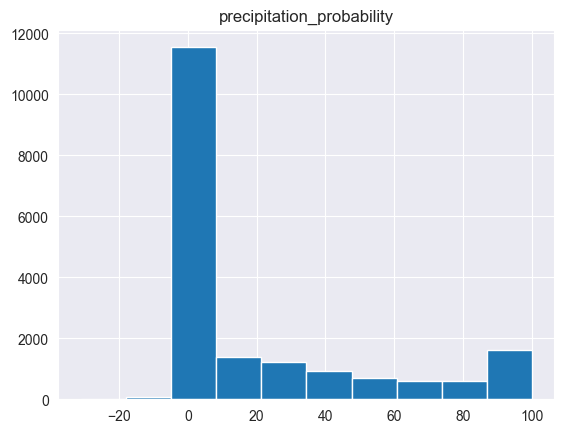

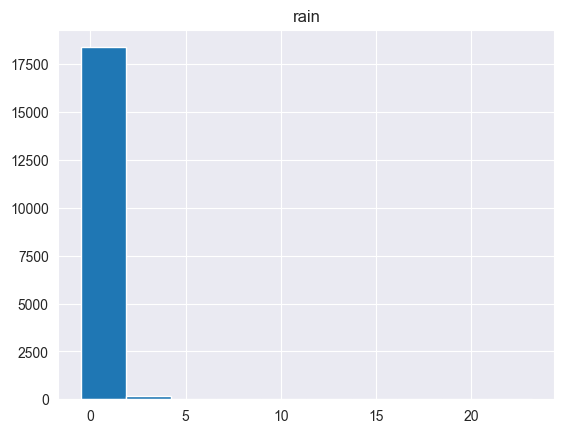

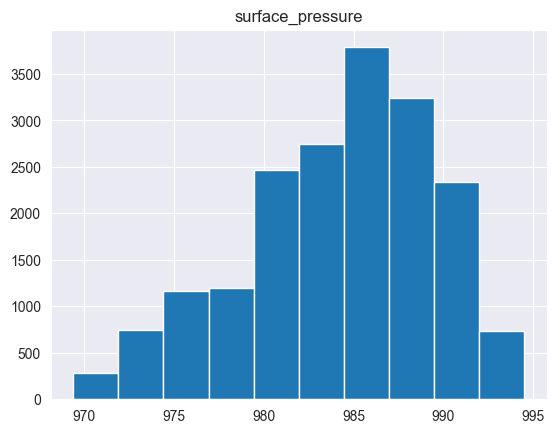

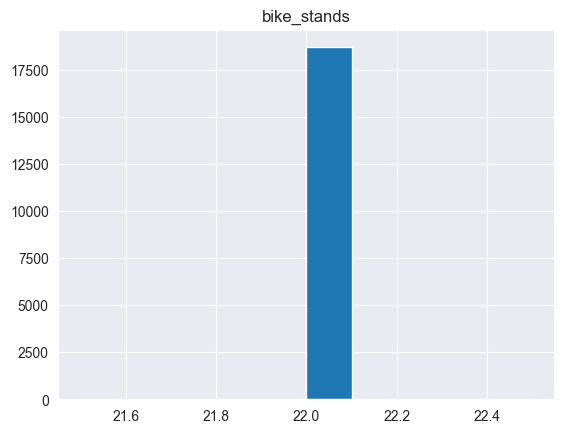

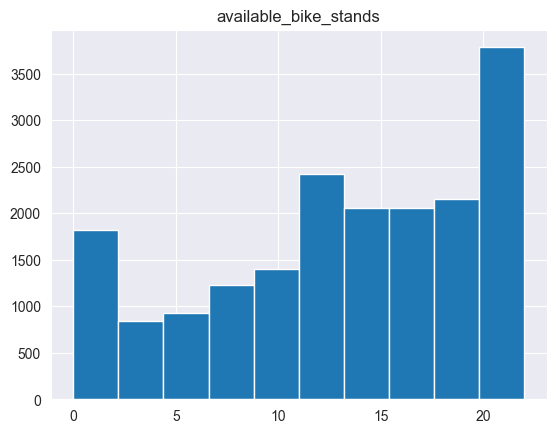

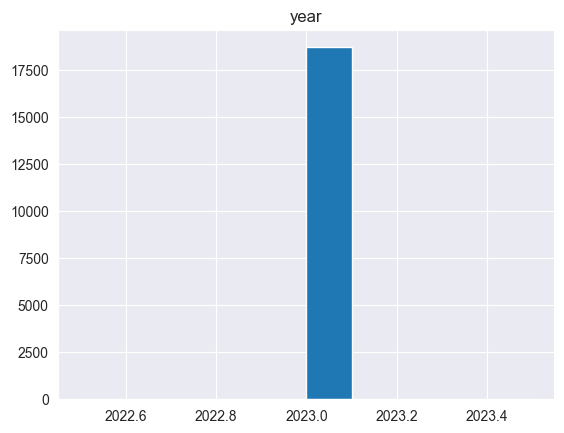

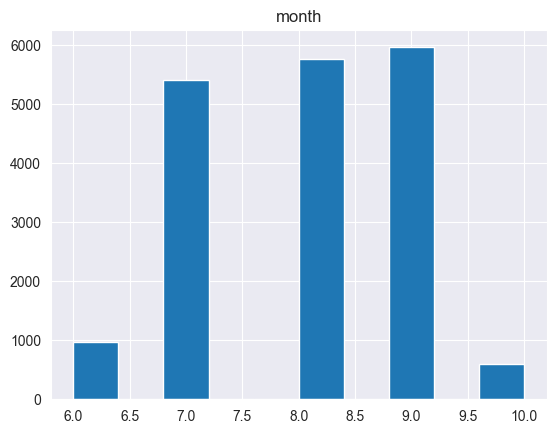

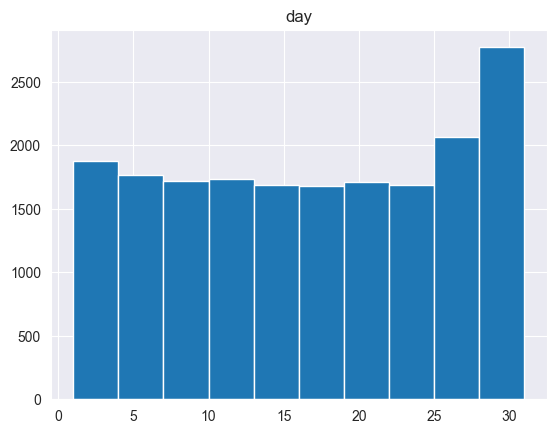

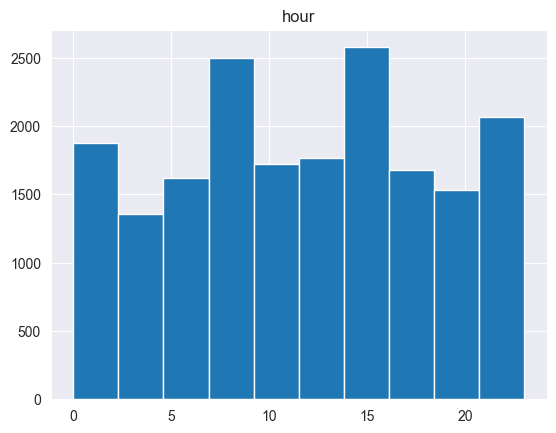

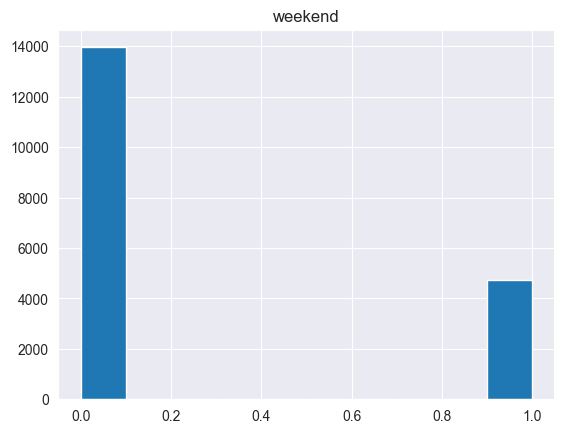

In [8]:
for column in df.select_dtypes(include='number').columns.tolist():
    plt.hist(df[column])
    plt.title(column)
    plt.show()

In [9]:
df['temperature'], _  = boxcox(df['temperature'])
df['relative_humidity'], _  = boxcox(df['relative_humidity'])
df['dew_point'], _ = boxcox(df['dew_point'])
df['apparent_temperature'], _ = boxcox(df['apparent_temperature'])

df['precipitation_probability'] = df['precipitation_probability']  + (abs(df['precipitation_probability'].min()) + 1)
df['precipitation_probability'], _ = boxcox(df['precipitation_probability'])

df['rain'] = df['rain'] + (abs(df['rain'].min()) + 1)
df['rain'], _ = boxcox(np.array(df['rain']))

df['surface_pressure'], _ = boxcox(df['surface_pressure'])

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


In [14]:
input_data = df.columns.tolist()
output_data = 'available_bike_stands'
input_data.remove(output_data)

ig_scores = mutual_info_regression(df[input_data], df[output_data])

feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)
feature_scores.head(13)

,Feature,Information_Gain
13,apparent_temperature_difference,0.922462
3,apparent_temperature,0.351461
6,surface_pressure,0.341995
0,temperature,0.273071
11,hour,0.208711
2,dew_point,0.205802
4,precipitation_probability,0.133597
1,relative_humidity,0.122484
10,day,0.120156
5,rain,0.051183


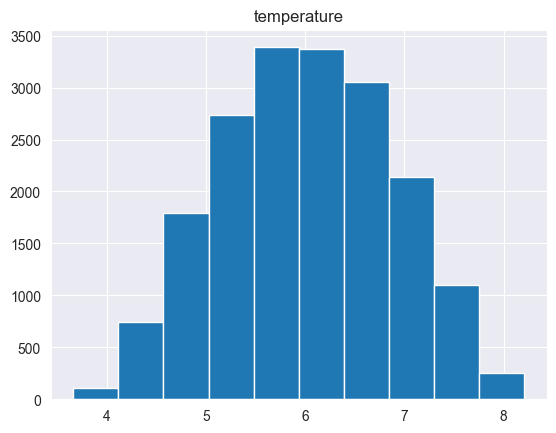

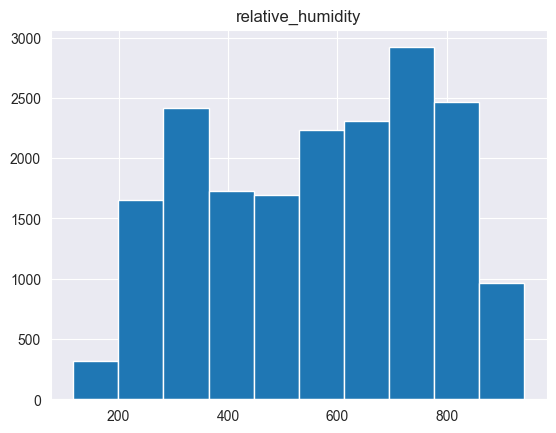

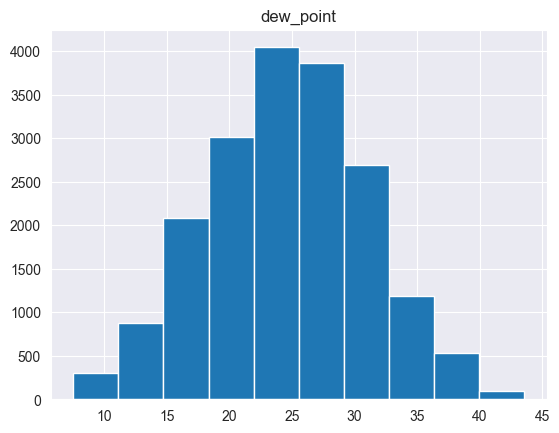

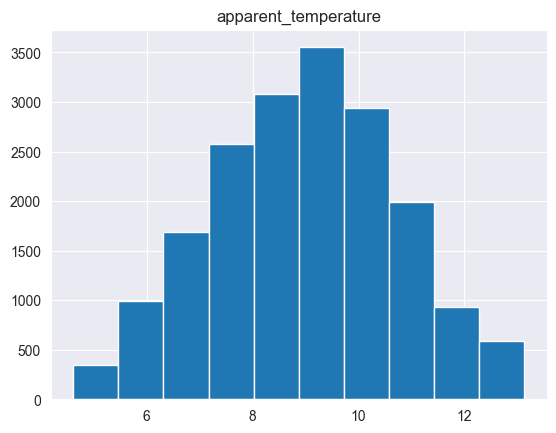

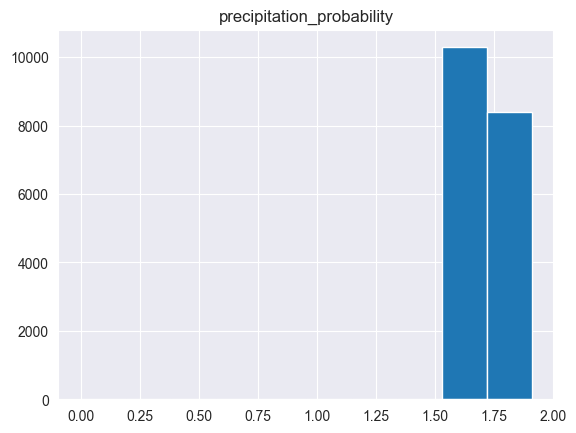

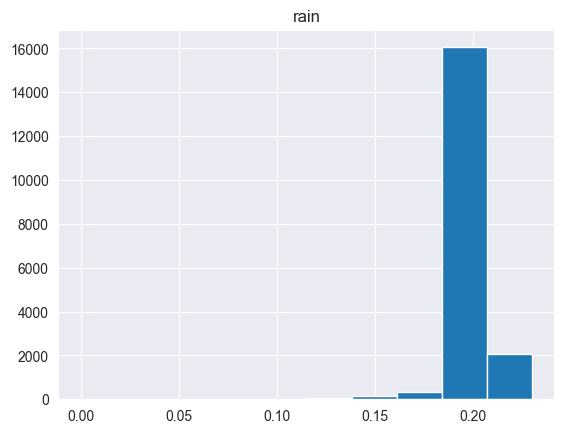

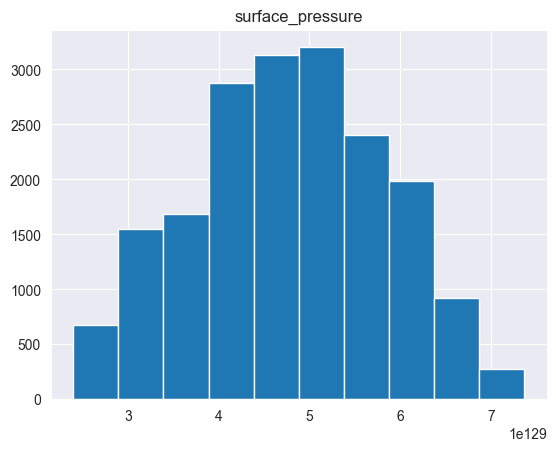

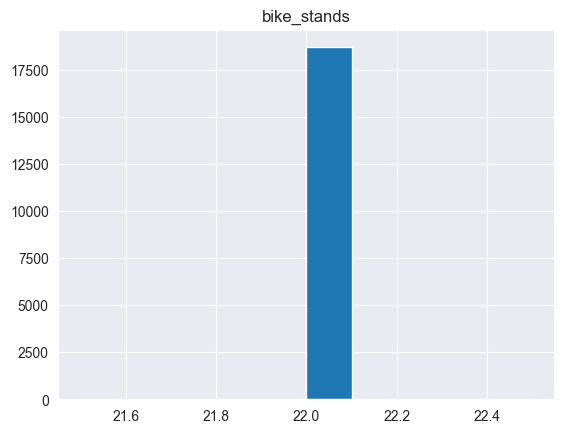

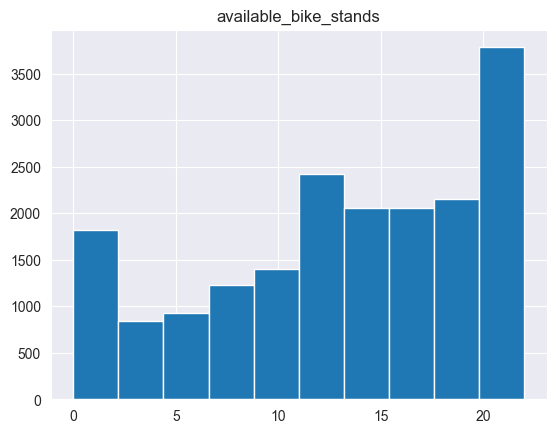

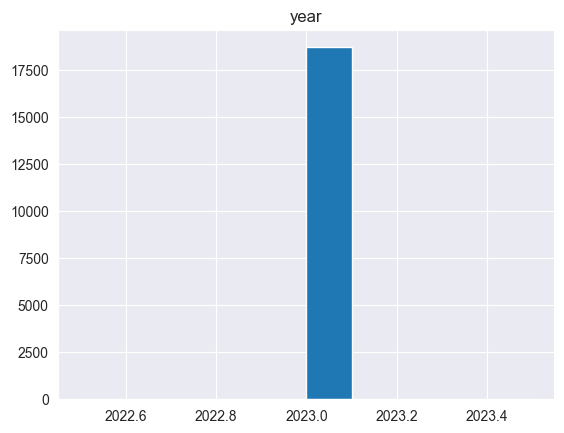

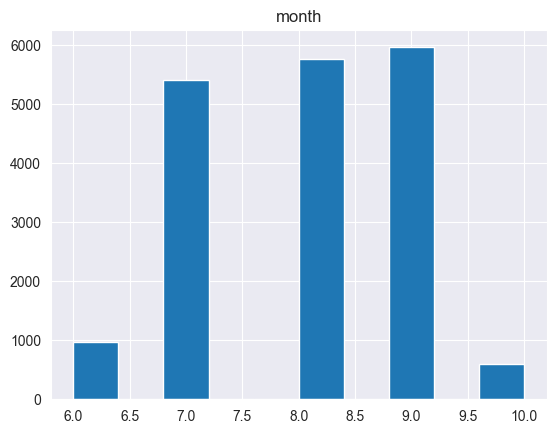

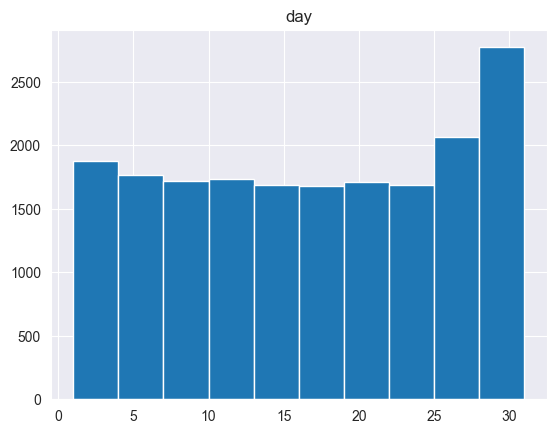

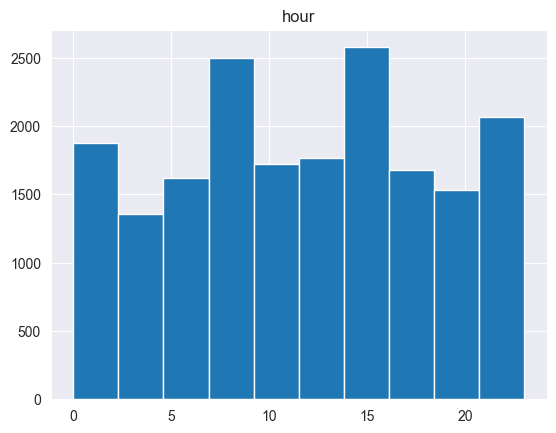

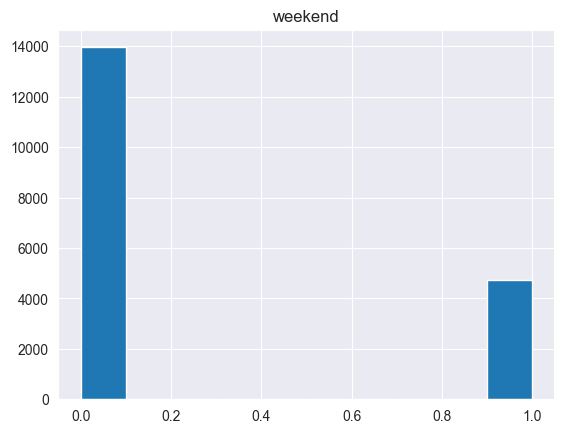

In [10]:
for column in df.select_dtypes(include='number').columns.tolist():
    plt.hist(df[column])
    plt.title(column)
    plt.show()

In [11]:
columns = df.columns.tolist()

scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])

In [12]:
normally_distributed = [
 'temperature',
 'relative_humidity',
 'dew_point',
 'apparent_temperature',
 'surface_pressure'
]

standard_scaler = StandardScaler()
df[normally_distributed] = standard_scaler.fit_transform(df[normally_distributed])

In [13]:
df['apparent_temperature_difference'] = df['temperature'] - df['apparent_temperature']

def get_daytime(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    else:
        return 3
    
df['daytime'] = df['hour'].apply(get_daytime)

In [15]:
input_data = feature_scores['Feature'].tolist()[:7]
print(input_data)

['apparent_temperature_difference', 'apparent_temperature', 'surface_pressure', 'temperature', 'hour', 'dew_point', 'precipitation_probability']


In [16]:
image_paths = []
labels = []

for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir, category)
    for image_file in os.listdir(category_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(category_dir, image_file)
            image_paths.append(image_path)
            labels.append(category)
            
print("Found {} images".format(len(image_paths)))
print("Classes: {}".format(np.unique(labels)))

Found 747 images
Classes: ['almond' 'banana' 'cardamom' 'cherry' 'chilli' 'clove' 'coconut'
 'coffee_plant' 'cotton' 'cucumber' 'fox_nut-makhana' 'gram' 'jowar'
 'jute' 'lemon' 'maize' 'mustard_oil' 'olive_tree' 'papaya'
 'pearl_millet-bajra' 'pineapple' 'rice' 'soyabean' 'sugarcane'
 'sunflower' 'tea' 'tobacco_plant' 'tomato' 'vigna_radiati-mung' 'wheat']


In [17]:
# images = [np.array(Image.open(image_path).convert('L')) for image_path in image_paths]
# images = [image.flatten() for image in images]
# images = np.array(images)

images = []

for folder in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, folder)):
        image = Image.open(os.path.join(data_dir, folder, file))

        new_width = image.width // 10
        new_height = image.height // 10

        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        image = resized_image.convert('L')

        image = np.array(image).flatten()

        images.append(image)

In [18]:
for i in range(len(image_paths)):
    image = cv2.imread(image_paths[i])
    # image = cv2.resize(image, (224, 224))
    image = image.astype("float32") / 255.0 # Zmnožimo s faktorjem za normalizacijo na območje [0, 1]
    image_paths[i] = image

In [19]:
regressors = [RandomForestRegressor(random_state=1234), BaggingRegressor(random_state=1234), AdaBoostRegressor(random_state=1234), GradientBoostingRegressor(random_state=1234), MLPRegressor(random_state=1234)]
classifiers = [BaggingClassifier(random_state=1234), RandomForestClassifier(random_state=1234), AdaBoostClassifier(random_state=1234), GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1234), MLPClassifier(random_state=1234)]

In [20]:
X = df[input_data]
y = df[output_data]

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [22]:
results = {regressor.__class__.__name__: {'MAE': [], 'MSE': [], 'Explained Variance': []} for regressor in regressors}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for regressor in regressors:
        reg = regressor.__class__.__name__

        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        ev = explained_variance_score(y_test, y_pred)

        results[reg]['MAE'].append(mae)
        results[reg]['MSE'].append(mse)
        results[reg]['Explained Variance'].append(ev)
        
print(results)

{'RandomForestRegressor': {'MAE': [0.04825080817861445, 0.05134923717337823, 0.05064544135558659, 0.05103358339463881, 0.049657767923582216], 'MSE': [0.005269612853091389, 0.0058497308246338794, 0.00576411720775147, 0.005908183233544722, 0.005455098946354551], 'Explained Variance': [0.9395592021354344, 0.9340368830136936, 0.9360480515867797, 0.9319387721379376, 0.9385619739472971]}, 'BaggingRegressor': {'MAE': [0.05070055621111445, 0.053406607479395685, 0.052962851491780434, 0.054209923603346206, 0.051605084615353854], 'MSE': [0.005833624669673479, 0.00652900042488028, 0.006539827785334391, 0.006696677491106325, 0.006144943332295845], 'Explained Variance': [0.9330997021278951, 0.9264155193424394, 0.9274450430762797, 0.9228499982929307, 0.9307920158999045]}, 'AdaBoostRegressor': {'MAE': [0.21336305785150392, 0.21723588112811534, 0.21245047027910977, 0.2163967444111831, 0.2095903137198874], 'MSE': [0.062046502160325215, 0.0642807615349374, 0.06206891860794457, 0.06372569421259405, 0.0617

In [23]:
avg_reg_results = {}
for model_name, model_scores in results.items():
    print(model_name, ':')
    avg_reg_results[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_reg_results[model_name][metric] = np.mean(scores)

RandomForestRegressor :
  MAE 0.05018736760516006
  MSE 0.005649348613075202
  Explained Variance 0.9360289765642286
BaggingRegressor :
  MAE 0.052577004680198124
  MSE 0.006348814740658064
  Explained Variance 0.9281204557478899
AdaBoostRegressor :
  MAE 0.21380729347795988
  MSE 0.06278144324082424
  Explained Variance 0.29715399023298883
GradientBoostingRegressor :
  MAE 0.17760008768978502
  MSE 0.047246517543665545
  Explained Variance 0.46509455863807664
MLPRegressor :
  MAE 0.17415893536111826
  MSE 0.04616493527783241
  Explained Variance 0.477584314495657


In [24]:
maes = {}
mses = {}
evs = {}

for i in results:
    maes[i] = results[i]['MAE']
    mses[i] = results[i]['MSE']
    evs[i] = results[i]['Explained Variance']

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

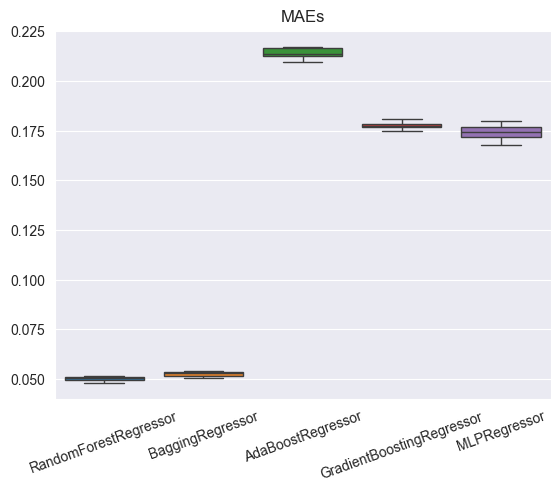

In [25]:
sns.boxplot(data=pd.DataFrame(maes)).set_title('MAEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

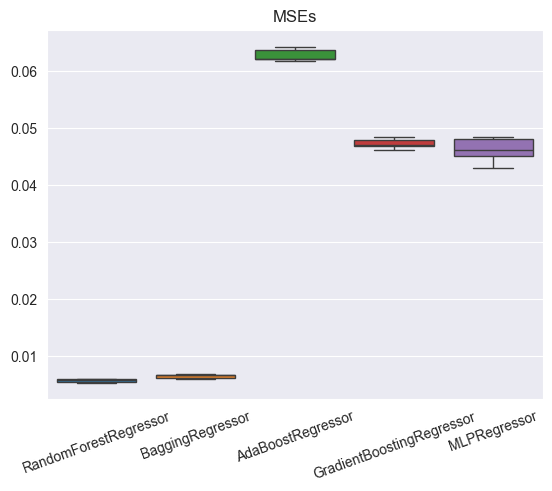

In [26]:
sns.boxplot(data=pd.DataFrame(mses)).set_title('MSEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

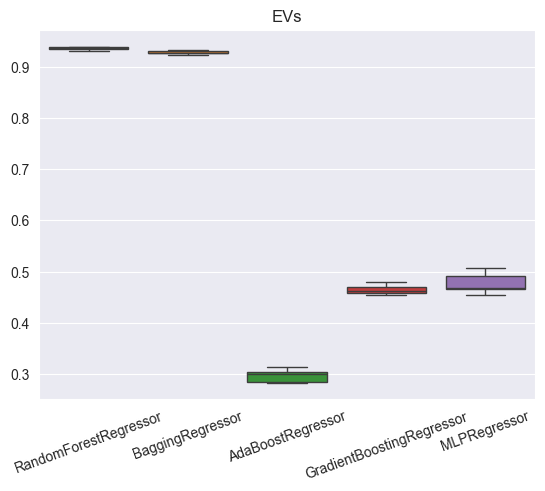

In [27]:
sns.boxplot(data=pd.DataFrame(evs)).set_title('EVs')
plt.xticks(rotation=20)

In [28]:
avg_maes = {}
avg_mses = {}
avg_evs = {}

for i in avg_reg_results:
    avg_maes[i] = avg_reg_results[i]['MAE']
    avg_mses[i] = avg_reg_results[i]['MSE']
    avg_evs[i] = avg_reg_results[i]['Explained Variance']
    
print(avg_maes)
print(avg_mses)
print(avg_evs)

{'RandomForestRegressor': 0.05018736760516006, 'BaggingRegressor': 0.052577004680198124, 'AdaBoostRegressor': 0.21380729347795988, 'GradientBoostingRegressor': 0.17760008768978502, 'MLPRegressor': 0.17415893536111826}
{'RandomForestRegressor': 0.005649348613075202, 'BaggingRegressor': 0.006348814740658064, 'AdaBoostRegressor': 0.06278144324082424, 'GradientBoostingRegressor': 0.047246517543665545, 'MLPRegressor': 0.04616493527783241}
{'RandomForestRegressor': 0.9360289765642286, 'BaggingRegressor': 0.9281204557478899, 'AdaBoostRegressor': 0.29715399023298883, 'GradientBoostingRegressor': 0.46509455863807664, 'MLPRegressor': 0.477584314495657}


([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

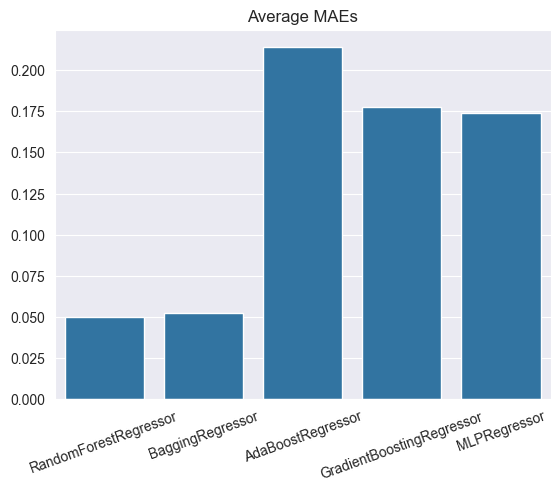

In [29]:
sns.barplot(x=list(avg_maes.keys()), y=list(avg_maes.values())).set_title('Average MAEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

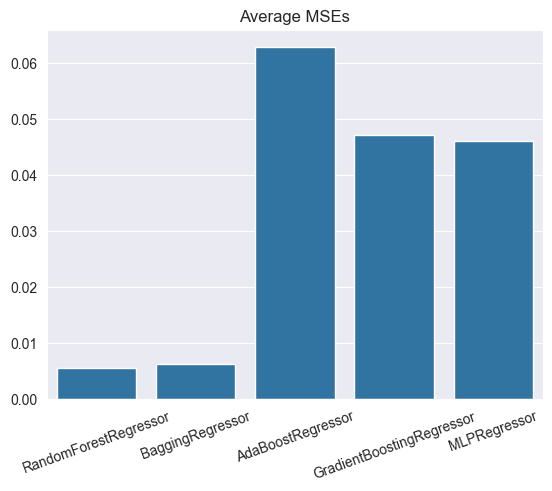

In [30]:
sns.barplot(x=list(avg_mses.keys()), y=list(avg_mses.values())).set_title('Average MSEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

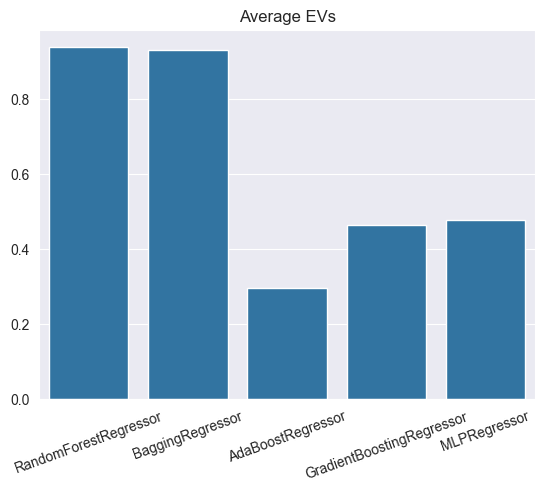

In [31]:
sns.barplot(x=list(avg_evs.keys()), y=list(avg_evs.values())).set_title('Average EVs')
plt.xticks(rotation=20)

In [32]:
X_clf = images
y_clf = np.array(labels)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

results_clf = {}
for classifier in classifiers:
    model_name = classifier.__class__.__name__
    clf_scores = {'Accuracy': [], 'F1 Weighted': [], 'Precision Weighted': [], 'Recall Weighted': []}

    for train_index, test_index in kf.split(X_clf, y_clf):
        X_train, X_test = np.array(X_clf)[train_index], np.array(X_clf)[test_index]
        y_train, y_test = np.array(y_clf)[train_index], np.array(y_clf)[test_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

        clf_scores['Accuracy'].append(accuracy)
        clf_scores['F1 Weighted'].append(f1)
        clf_scores['Precision Weighted'].append(precision)
        clf_scores['Recall Weighted'].append(recall)

    results_clf[model_name] = clf_scores

print(results_clf)

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

{'BaggingClassifier': {'Accuracy': [0.14, 0.16, 0.18120805369127516, 0.21476510067114093, 0.1476510067114094], 'F1 Weighted': [0.1321978217860571, 0.15312707662707664, 0.1632020105174468, 0.20388232200312736, 0.149203093261522], 'Precision Weighted': [0.20122222222222222, 0.253957671957672, 0.23065573501815112, 0.2490332374560563, 0.24872163630552893], 'Recall Weighted': [0.14, 0.16, 0.18120805369127516, 0.21476510067114093, 0.1476510067114094]}, 'RandomForestClassifier': {'Accuracy': [0.15333333333333332, 0.22, 0.2348993288590604, 0.20134228187919462, 0.18120805369127516], 'F1 Weighted': [0.1651117965854808, 0.21472722049192636, 0.2194308003703977, 0.17778530194637576, 0.1666541698420893], 'Precision Weighted': [0.34329629629629627, 0.3337910052910053, 0.31861980301577614, 0.27328752530094813, 0.2748727782284829], 'Recall Weighted': [0.15333333333333332, 0.22, 0.2348993288590604, 0.20134228187919462, 0.18120805369127516]}, 'AdaBoostClassifier': {'Accuracy': [0.02666666666666667, 0.073

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
accuracy = {}
f1 = {}
precision = {}
recall = {}

for i in results_clf:
    accuracy[i] = results_clf[i]['Accuracy']
    f1[i] = results_clf[i]['F1 Weighted']
    precision[i] = results_clf[i]['Precision Weighted']
    recall[i] = results_clf[i]['Recall Weighted']

In [35]:
avg_clf_results = {}
for model_name, model_scores in results_clf.items():
    print(model_name, ':')
    avg_clf_results[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_clf_results[model_name][metric] = np.mean(scores)

BaggingClassifier :
  Accuracy 0.1687248322147651
  F1 Weighted 0.160322464839046
  Precision Weighted 0.23671810059192616
  Recall Weighted 0.1687248322147651
RandomForestClassifier :
  Accuracy 0.19815659955257267
  F1 Weighted 0.188741857847254
  Precision Weighted 0.30877348162650176
  Recall Weighted 0.19815659955257267
AdaBoostClassifier :
  Accuracy 0.0548993288590604
  F1 Weighted 0.03189506156128545
  Precision Weighted 0.4601411781400973
  Recall Weighted 0.0548993288590604
GradientBoostingClassifier :
  Accuracy 0.0549351230425056
  F1 Weighted 0.04410650509292437
  Precision Weighted 0.4234307824437278
  Recall Weighted 0.0549351230425056
MLPClassifier :
  Accuracy 0.029476510067114096
  F1 Weighted 0.017684006575884786
  Precision Weighted 0.25864270391555577
  Recall Weighted 0.029476510067114096


([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

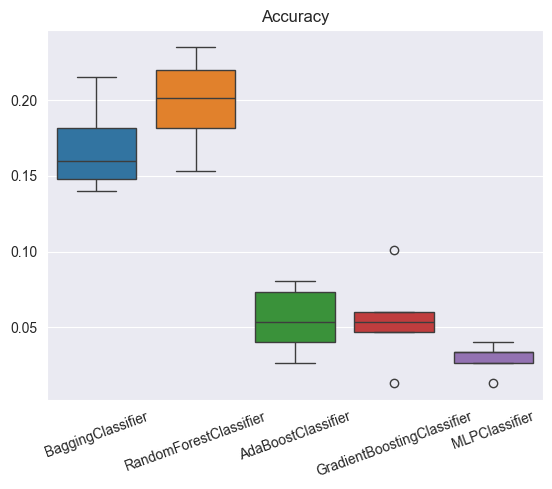

In [36]:
sns.boxplot(data=pd.DataFrame(accuracy)).set_title('Accuracy')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

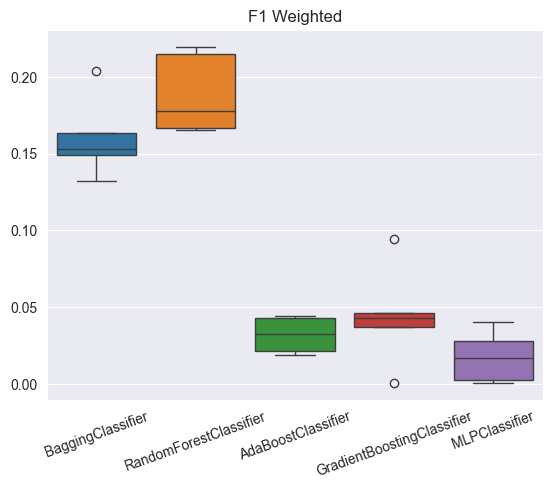

In [37]:
sns.boxplot(data=pd.DataFrame(f1)).set_title('F1 Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

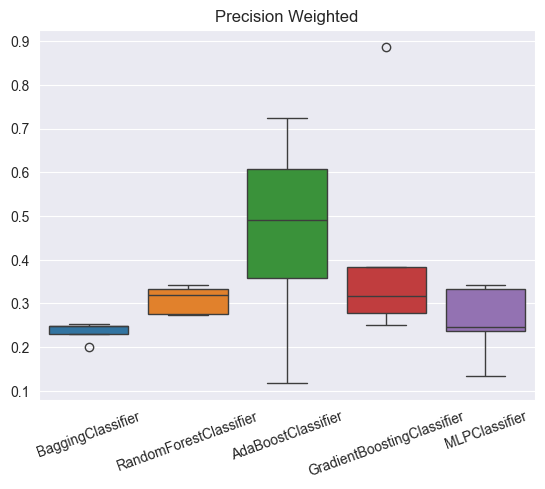

In [38]:
sns.boxplot(data=pd.DataFrame(precision)).set_title('Precision Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

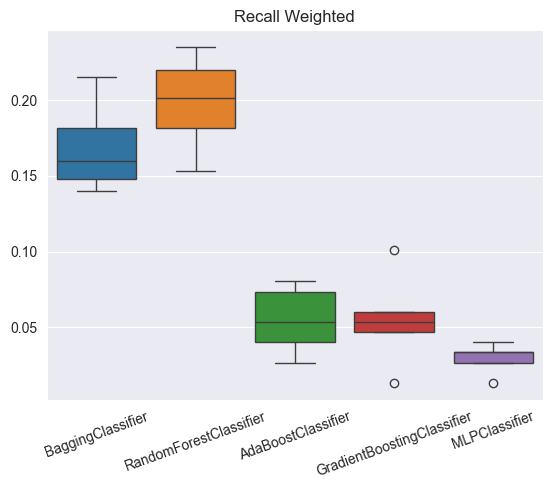

In [39]:
sns.boxplot(data=pd.DataFrame(recall)).set_title('Recall Weighted')
plt.xticks(rotation=20)

In [40]:
avg_accuracy = {}
avg_f1 = {}
avg_precision = {}
avg_recall = {}

for i in avg_clf_results:
    avg_accuracy[i] = avg_clf_results[i]['Accuracy']
    avg_f1[i] = avg_clf_results[i]['F1 Weighted']
    avg_precision[i] = avg_clf_results[i]['Precision Weighted']
    avg_recall[i] = avg_clf_results[i]['Recall Weighted']

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

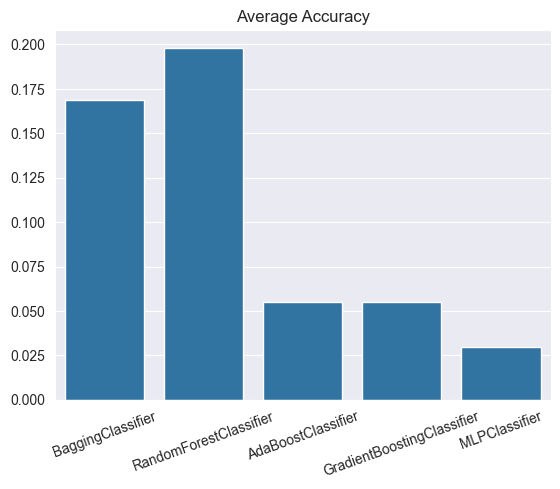

In [41]:
sns.barplot(x=list(avg_accuracy.keys()), y=list(avg_accuracy.values())).set_title('Average Accuracy')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

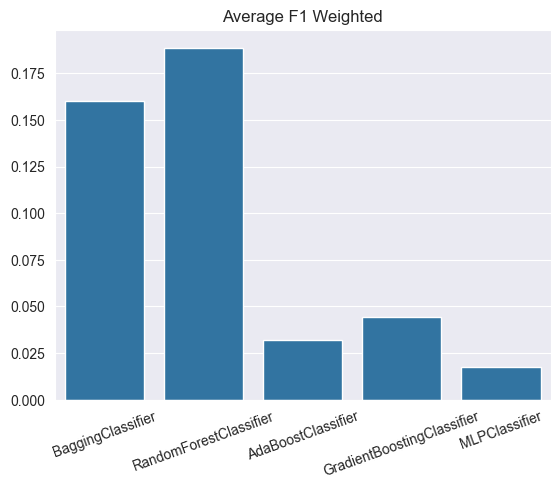

In [42]:
sns.barplot(x=list(avg_f1.keys()), y=list(avg_f1.values())).set_title('Average F1 Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

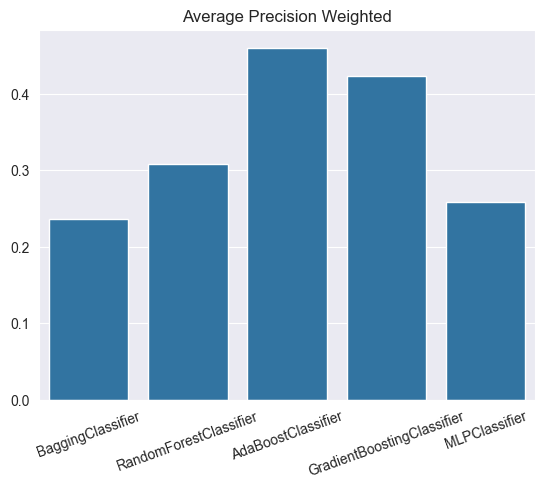

In [43]:
sns.barplot(x=list(avg_precision.keys()), y=list(avg_precision.values())).set_title('Average Precision Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

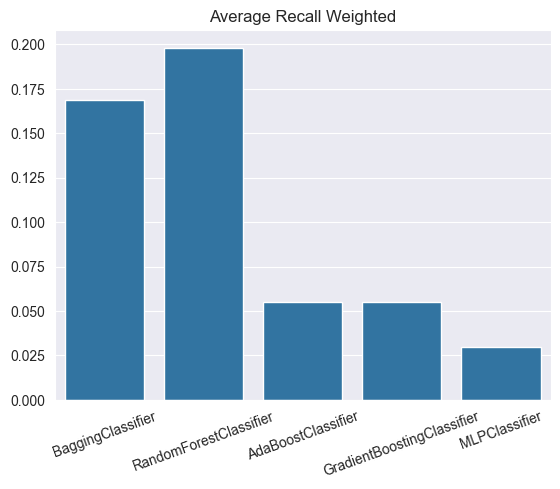

In [44]:
sns.barplot(x=list(avg_recall.keys()), y=list(avg_recall.values())).set_title('Average Recall Weighted')
plt.xticks(rotation=20)

Dodatni del naloge

In [45]:
data_dir = 'agriculture-crops'
df = pd.read_csv('mbajk_dataset.csv')

In [46]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.isnull().sum()

date                            0
temperature                  1869
relative_humidity               0
dew_point                       0
apparent_temperature            0
precipitation_probability    1308
rain                         2804
surface_pressure                0
bike_stands                     0
available_bike_stands           0
dtype: int64

In [47]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

#dodana prva dodatna značilnica, da lahko potem odstarnim datum
df['weekend'] = np.where(df['date'].dt.dayofweek > 4, 1, 0)
df.drop('date', axis=1, inplace=True)

In [48]:
input_data = df.columns.tolist()
output_data = ['temperature', 'precipitation_probability', 'rain']
for i in output_data: input_data.remove(i)

for column in output_data:
    # izbereš vrstice manjkajočih vrednosti
    test_data = df[df[column].isnull()]
    # kopija za obdelavo
    df_copy = df.copy()
    df_copy.dropna(subset=[column], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df_copy[input_data], df_copy[column], test_size=0.30)
    reg = RandomForestRegressor().fit(X_train, y_train)
    pred = reg.predict(test_data[input_data])
    # lociras vrstice in jih zapolnis z napovedanimi vrednostmi
    df.loc[test_data.index, column] = pred
    
df.isnull().sum()

temperature                  0
relative_humidity            0
dew_point                    0
apparent_temperature         0
precipitation_probability    0
rain                         0
surface_pressure             0
bike_stands                  0
available_bike_stands        0
year                         0
month                        0
day                          0
hour                         0
weekend                      0
dtype: int64

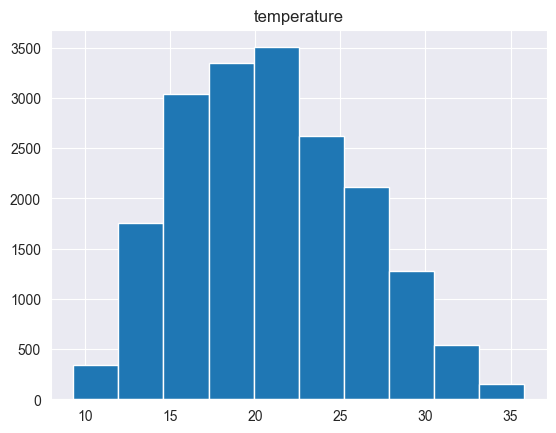

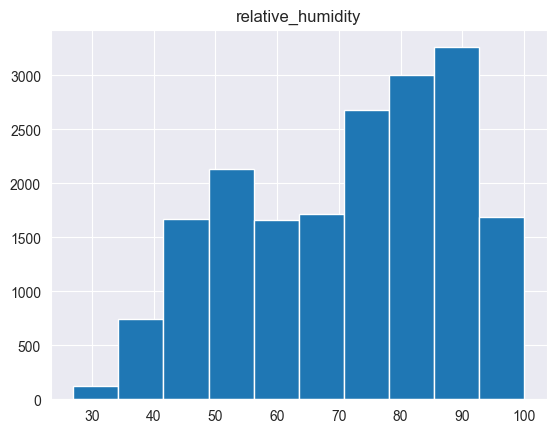

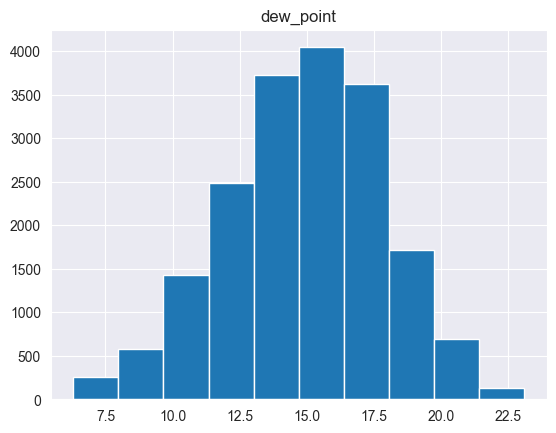

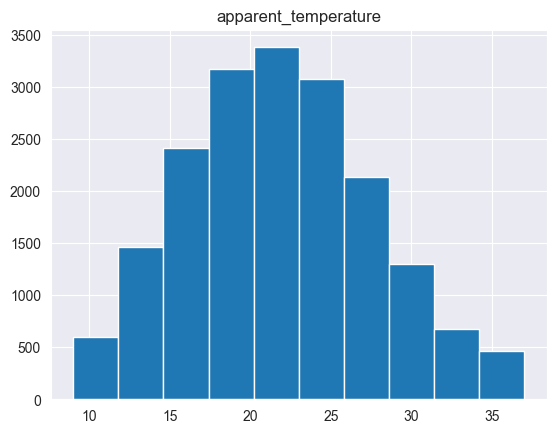

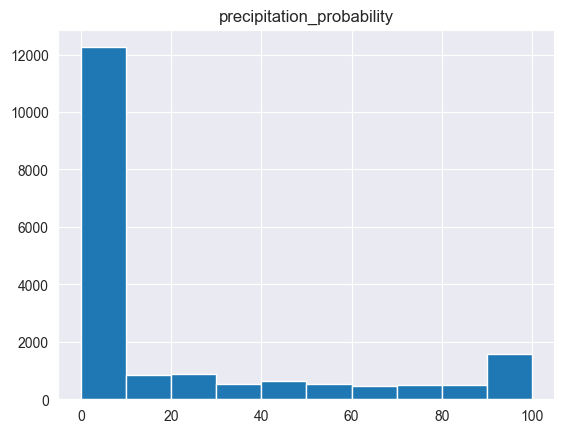

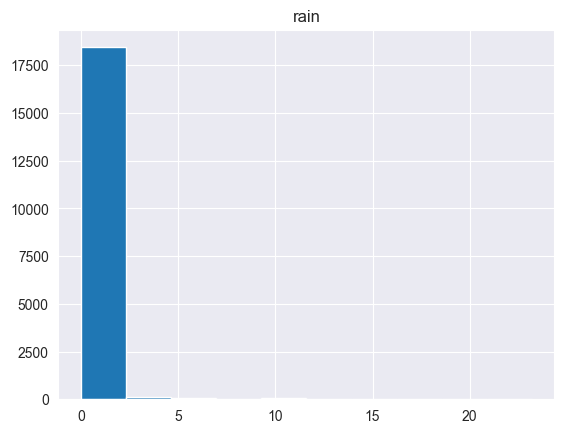

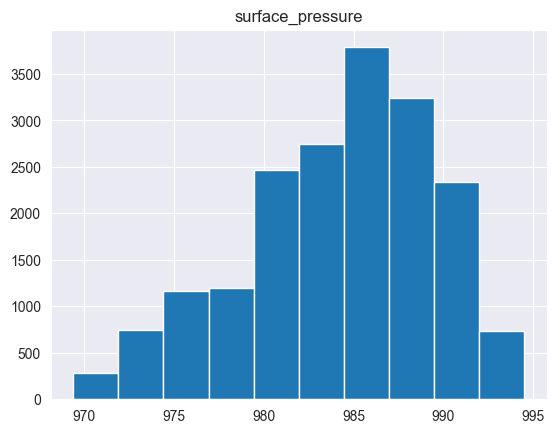

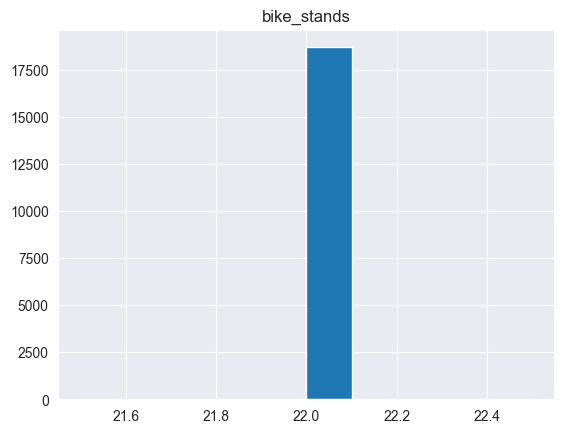

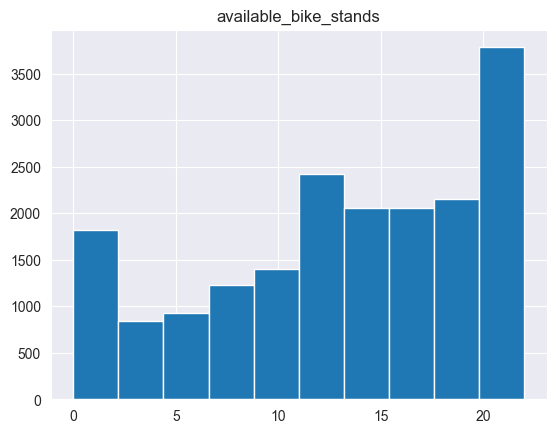

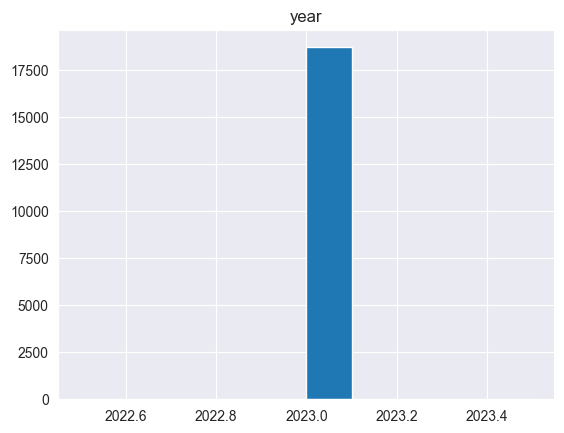

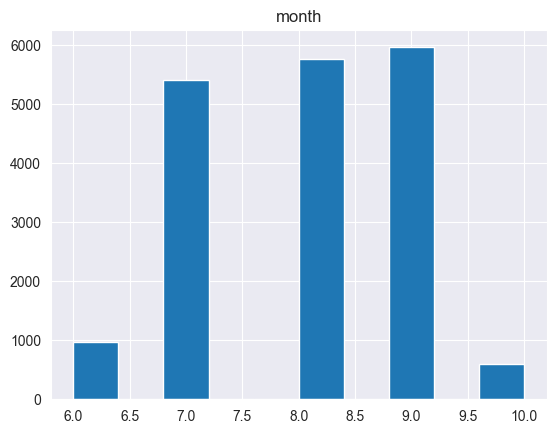

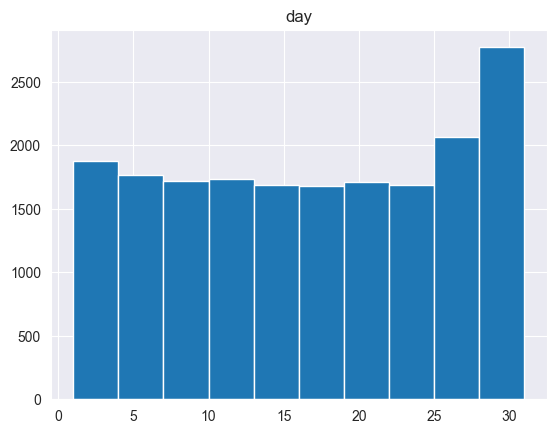

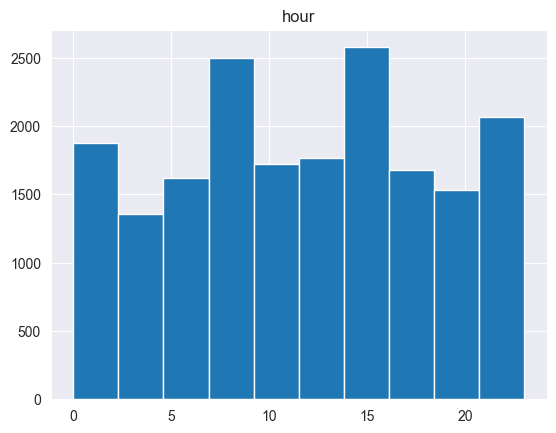

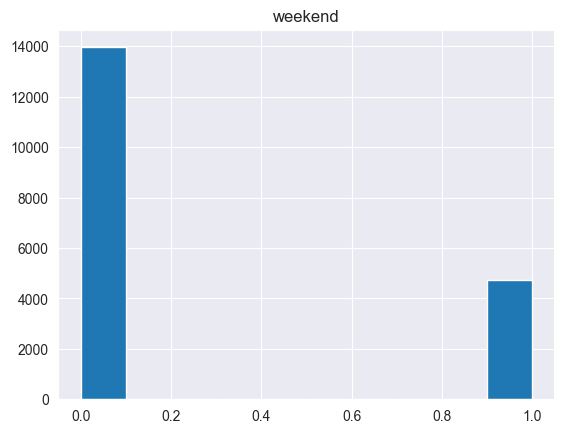

In [49]:
for column in df.select_dtypes(include='number').columns.tolist():
    plt.hist(df[column])
    plt.title(column)
    plt.show()

In [50]:
df['temperature'], _  = boxcox(df['temperature'])
df['relative_humidity'], _  = boxcox(df['relative_humidity'])
df['dew_point'], _ = boxcox(df['dew_point'])
df['apparent_temperature'], _ = boxcox(df['apparent_temperature'])

df['precipitation_probability'] = df['precipitation_probability']  + (abs(df['precipitation_probability'].min()) + 1)
df['precipitation_probability'], _ = boxcox(df['precipitation_probability'])

df['rain'] = df['rain'] + (abs(df['rain'].min()) + 1)
df['rain'], _ = boxcox(np.array(df['rain']))

df['surface_pressure'], _ = boxcox(df['surface_pressure'])

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


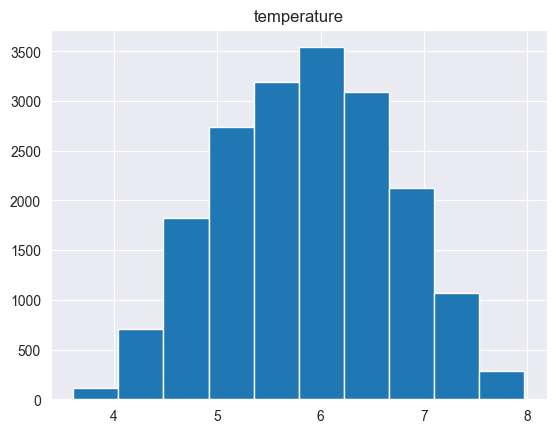

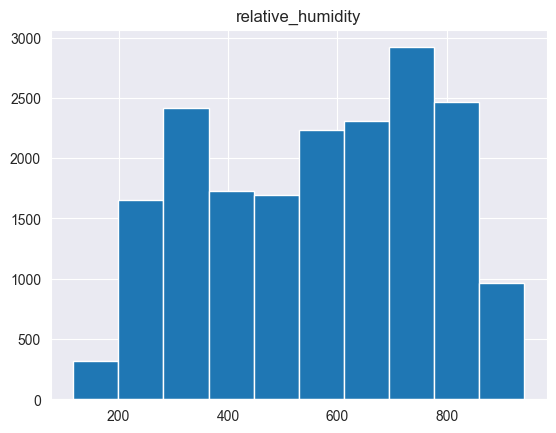

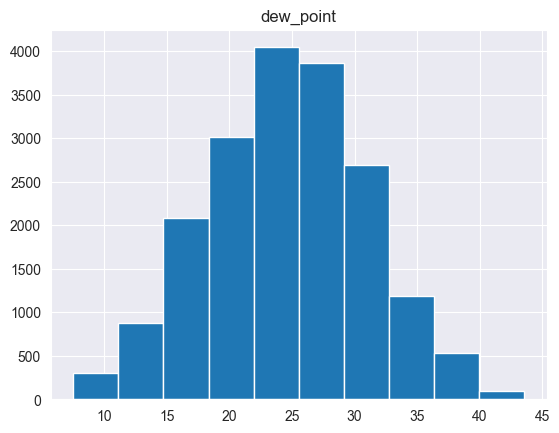

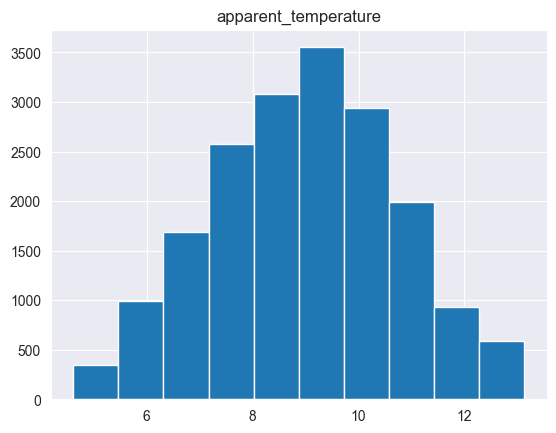

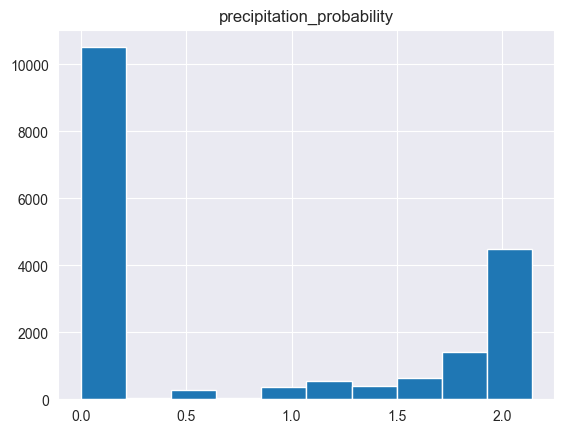

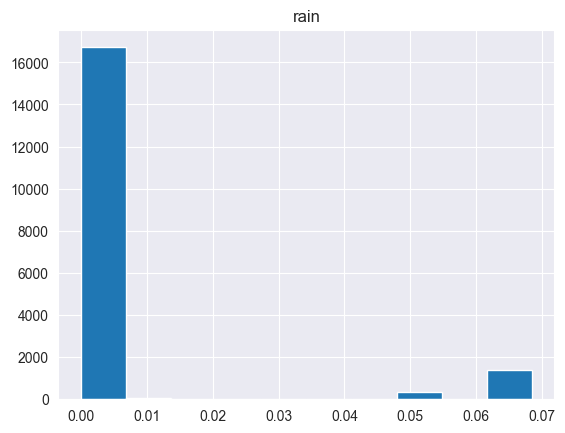

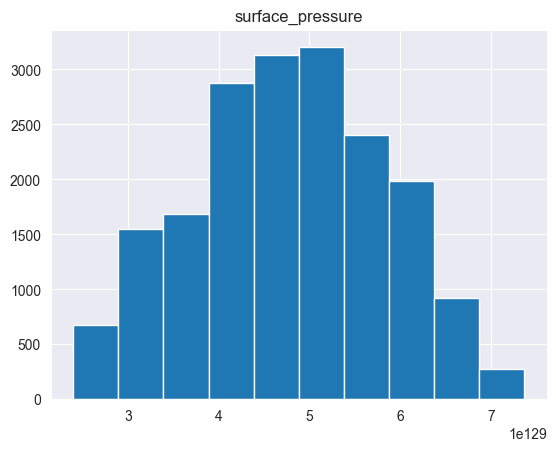

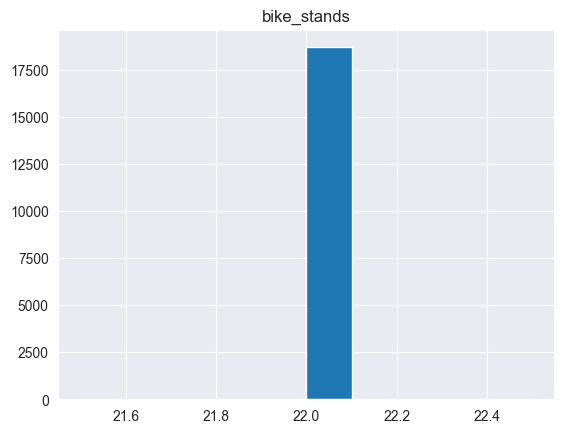

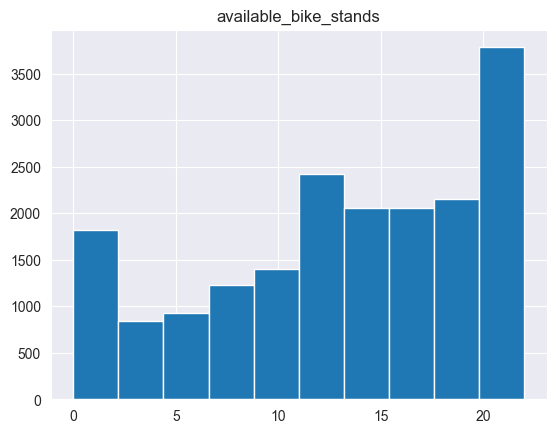

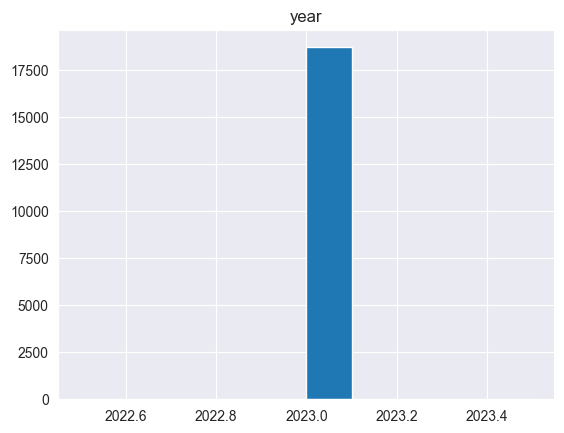

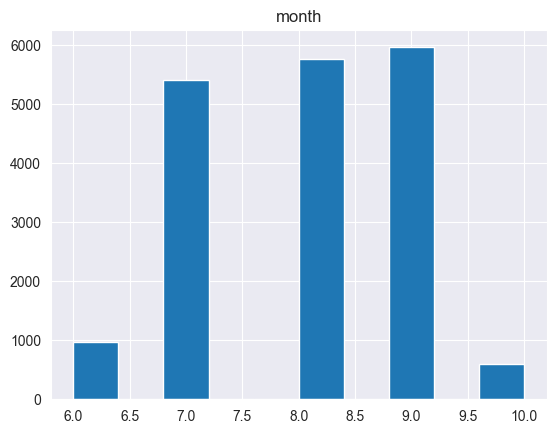

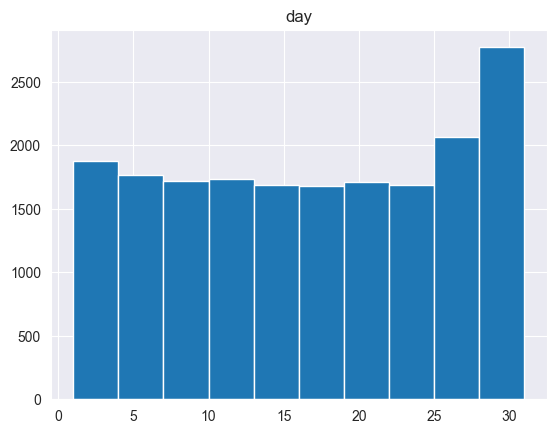

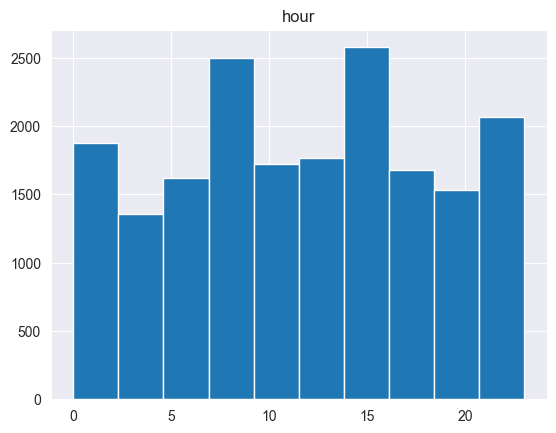

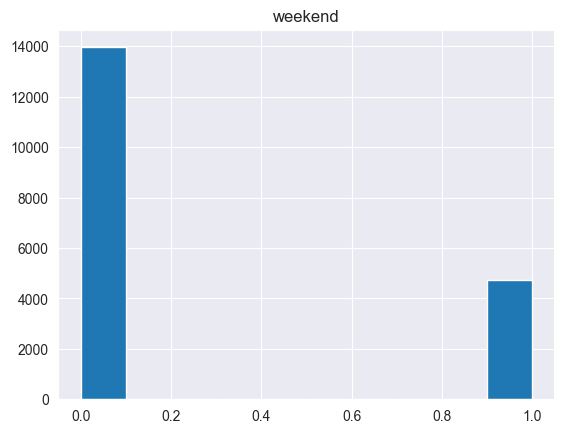

In [51]:
for column in df.select_dtypes(include='number').columns.tolist():
    plt.hist(df[column])
    plt.title(column)
    plt.show()

In [52]:
columns = df.columns.tolist()

scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])

In [53]:
normally_distributed = [
 'temperature',
 'relative_humidity',
 'dew_point',
 'apparent_temperature',
 'surface_pressure'
]

standard_scaler = StandardScaler()
df[normally_distributed] = standard_scaler.fit_transform(df[normally_distributed])

In [54]:
df['apparent_temperature_difference'] = df['temperature'] - df['apparent_temperature']

def get_daytime(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    else:
        return 3
    
df['daytime'] = df['hour'].apply(get_daytime)

In [55]:
input_data = df.columns.tolist()
output_data = 'available_bike_stands'
input_data.remove(output_data)

ig_scores = mutual_info_regression(df[input_data], df[output_data])

feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)
feature_scores.head(10)

,Feature,Information_Gain
13,apparent_temperature_difference,0.971848
3,apparent_temperature,0.351025
6,surface_pressure,0.337734
0,temperature,0.295131
2,dew_point,0.212177
11,hour,0.198890
4,precipitation_probability,0.145333
1,relative_humidity,0.120415
10,day,0.117387
5,rain,0.039693


In [56]:
input_data = feature_scores['Feature'].tolist()[:7]
print(input_data)

['apparent_temperature_difference', 'apparent_temperature', 'surface_pressure', 'temperature', 'dew_point', 'hour', 'precipitation_probability']


In [57]:
image_paths = []
labels = []

for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir, category)
    for image_file in os.listdir(category_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(category_dir, image_file)
            image_paths.append(image_path)
            labels.append(category)
            
print("Found {} images".format(len(image_paths)))
print("Classes: {}".format(np.unique(labels)))

Found 747 images
Classes: ['almond' 'banana' 'cardamom' 'cherry' 'chilli' 'clove' 'coconut'
 'coffee_plant' 'cotton' 'cucumber' 'fox_nut-makhana' 'gram' 'jowar'
 'jute' 'lemon' 'maize' 'mustard_oil' 'olive_tree' 'papaya'
 'pearl_millet-bajra' 'pineapple' 'rice' 'soyabean' 'sugarcane'
 'sunflower' 'tea' 'tobacco_plant' 'tomato' 'vigna_radiati-mung' 'wheat']


In [58]:
images = []

for folder in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, folder)):
        image = Image.open(os.path.join(data_dir, folder, file))

        new_width = image.width // 10
        new_height = image.height // 10

        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        image = resized_image.convert('L')
        
        image = np.array(image)
        edge_image = filters.sobel(image)
        image = edge_image.flatten()

        images.append(image)

In [59]:
for i in range(len(image_paths)):
    image = cv2.imread(image_paths[i])
    # image = cv2.resize(image, (224, 224))
    image = image.astype("float32") / 255.0 # Zmnožimo s faktorjem za normalizacijo na območje [0, 1]
    image_paths[i] = image

In [60]:
regressors = [RandomForestRegressor(random_state=1234), BaggingRegressor(random_state=1234), AdaBoostRegressor(random_state=1234), GradientBoostingRegressor(random_state=1234), MLPRegressor(random_state=1234)]
classifiers = [BaggingClassifier(random_state=1234), RandomForestClassifier(random_state=1234), AdaBoostClassifier(random_state=1234), GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1234), MLPClassifier(random_state=1234)]

In [61]:
X = df[input_data]
y = df[output_data]

In [62]:
X_clf = images
y_clf = np.array(labels)

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [64]:
results_2 = {regressor.__class__.__name__: {'MAE': [], 'MSE': [], 'Explained Variance': []} for regressor in regressors}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for regressor in regressors:
        reg = regressor.__class__.__name__

        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        ev = explained_variance_score(y_test, y_pred)

        results_2[reg]['MAE'].append(mae)
        results_2[reg]['MSE'].append(mse)
        results_2[reg]['Explained Variance'].append(ev)
        
print(results_2)

{'RandomForestRegressor': {'MAE': [0.043424611733897625, 0.045083979523765846, 0.043585112981189555, 0.04530709907880493, 0.04440126572993569], 'MSE': [0.004132955117804299, 0.004433082637018107, 0.004085450769252415, 0.00452442533237312, 0.00419656478539267], 'Explained Variance': [0.9525825140498871, 0.9500136525282402, 0.9546791122352083, 0.9478755810663794, 0.9527372419870569]}, 'BaggingRegressor': {'MAE': [0.045263327687438425, 0.04634565945969594, 0.04602484842753704, 0.048392208265438975, 0.046068609454626534], 'MSE': [0.004564912268330221, 0.00488241178873509, 0.004636805016266076, 0.005222027657215778, 0.004614664116338173], 'Explained Variance': [0.9476390778387452, 0.9449688001330061, 0.9485816817350416, 0.9398387337627161, 0.948020112416015]}, 'AdaBoostRegressor': {'MAE': [0.21020252215808974, 0.21644983809980042, 0.21123882702462946, 0.20945698839946972, 0.21406677242584], 'MSE': [0.061192195459840525, 0.0636676982897928, 0.06142006408052948, 0.06154676645232225, 0.0624182

In [65]:
avg_reg_results_2 = {}
for model_name, model_scores in results_2.items():
    print(model_name, ':')
    avg_reg_results_2[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_reg_results_2[model_name][metric] = np.mean(scores)

RandomForestRegressor :
  MAE 0.04436041380951873
  MSE 0.0042744957283681224
  Explained Variance 0.9515776203733542
BaggingRegressor :
  MAE 0.04641893065894738
  MSE 0.0047841641693770675
  Explained Variance 0.9458096811771048
AdaBoostRegressor :
  MAE 0.21228298962156583
  MSE 0.062049004504064344
  Explained Variance 0.3022229451205885
GradientBoostingRegressor :
  MAE 0.1763144520922611
  MSE 0.04661551161787662
  Explained Variance 0.4722650255376471
MLPRegressor :
  MAE 0.1639652771065307
  MSE 0.0416830672433096
  Explained Variance 0.5321687439647873


In [66]:
maes_2 = {}
mses_2 = {}
evs_2 = {}

for i in results_2:
    maes_2[i] = results_2[i]['MAE']
    mses_2[i] = results_2[i]['MSE']
    evs_2[i] = results_2[i]['Explained Variance']

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

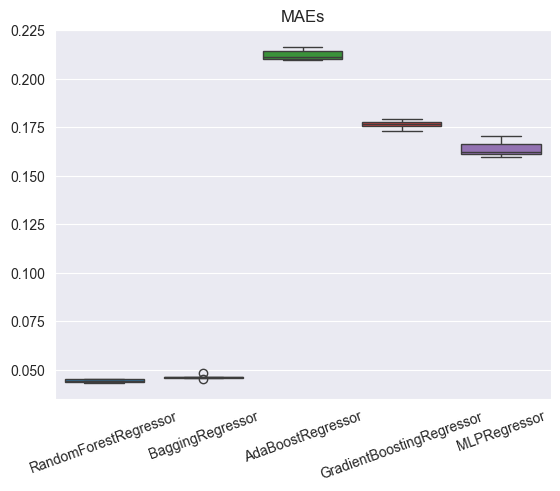

In [67]:
sns.boxplot(data=pd.DataFrame(maes_2)).set_title('MAEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

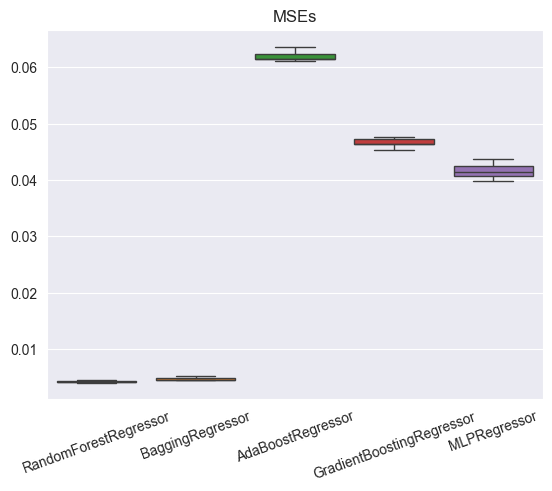

In [68]:
sns.boxplot(data=pd.DataFrame(mses_2)).set_title('MSEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

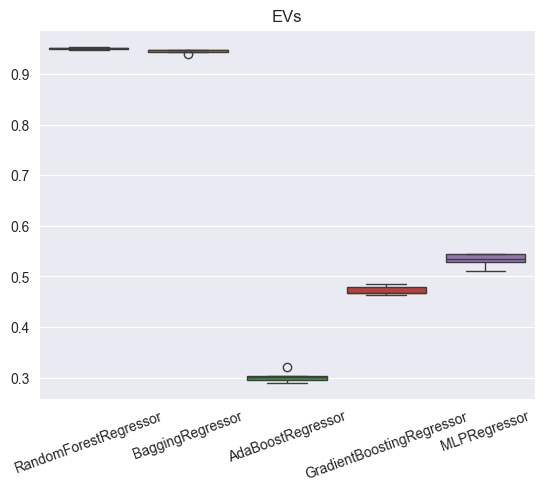

In [69]:
sns.boxplot(data=pd.DataFrame(evs_2)).set_title('EVs')
plt.xticks(rotation=20)

In [70]:
avg_maes_2 = {}
avg_mses_2 = {}
avg_evs_2 = {}

for i in avg_reg_results_2:
    avg_maes_2[i] = avg_reg_results_2[i]['MAE']
    avg_mses_2[i] = avg_reg_results_2[i]['MSE']
    avg_evs_2[i] = avg_reg_results_2[i]['Explained Variance']
    
print(avg_maes_2)
print(avg_mses_2)
print(avg_evs_2)

{'RandomForestRegressor': 0.04436041380951873, 'BaggingRegressor': 0.04641893065894738, 'AdaBoostRegressor': 0.21228298962156583, 'GradientBoostingRegressor': 0.1763144520922611, 'MLPRegressor': 0.1639652771065307}
{'RandomForestRegressor': 0.0042744957283681224, 'BaggingRegressor': 0.0047841641693770675, 'AdaBoostRegressor': 0.062049004504064344, 'GradientBoostingRegressor': 0.04661551161787662, 'MLPRegressor': 0.0416830672433096}
{'RandomForestRegressor': 0.9515776203733542, 'BaggingRegressor': 0.9458096811771048, 'AdaBoostRegressor': 0.3022229451205885, 'GradientBoostingRegressor': 0.4722650255376471, 'MLPRegressor': 0.5321687439647873}


([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

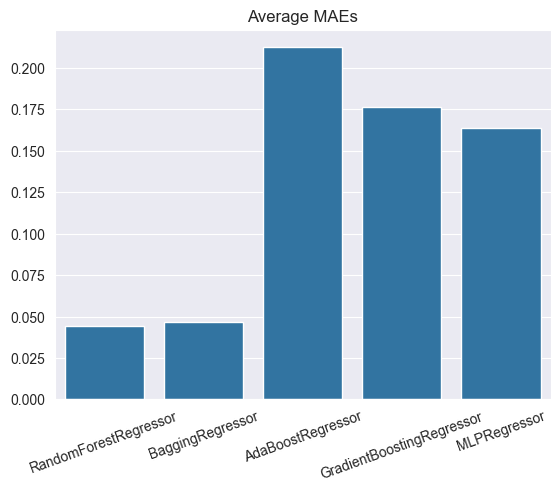

In [71]:
sns.barplot(x=list(avg_maes_2.keys()), y=list(avg_maes_2.values())).set_title('Average MAEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

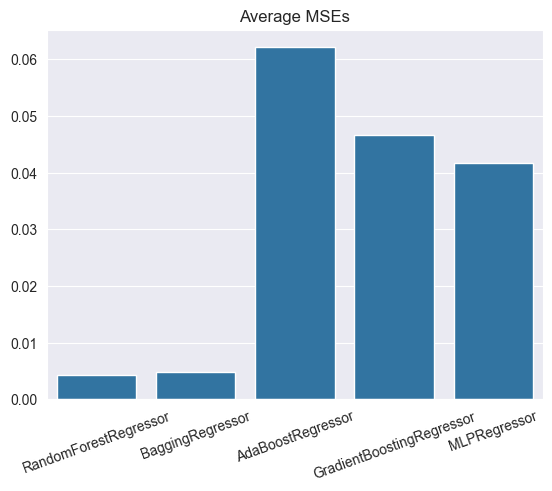

In [72]:
sns.barplot(x=list(avg_mses_2.keys()), y=list(avg_mses_2.values())).set_title('Average MSEs')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor')])

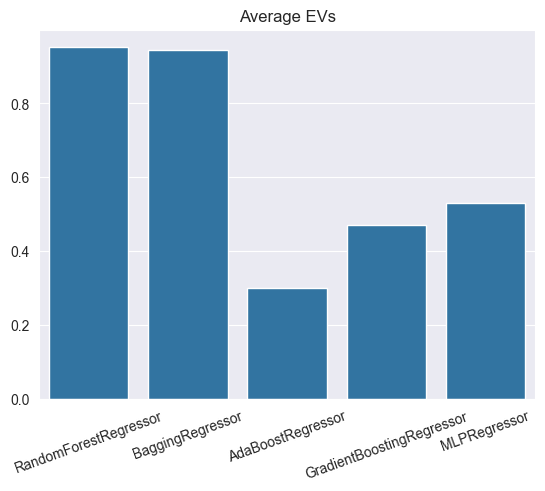

In [73]:
sns.barplot(x=list(avg_evs_2.keys()), y=list(avg_evs_2.values())).set_title('Average EVs')
plt.xticks(rotation=20)

In [74]:
results_clf_2 = {}
for classifier in classifiers:
    model_name = classifier.__class__.__name__
    clf_scores = {'Accuracy': [], 'F1 Weighted': [], 'Precision Weighted': [], 'Recall Weighted': []}

    for train_index, test_index in kf.split(X_clf, y_clf):
        X_train, X_test = np.array(X_clf)[train_index], np.array(X_clf)[test_index]
        y_train, y_test = np.array(y_clf)[train_index], np.array(y_clf)[test_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

        clf_scores['Accuracy'].append(accuracy)
        clf_scores['F1 Weighted'].append(f1)
        clf_scores['Precision Weighted'].append(precision)
        clf_scores['Recall Weighted'].append(recall)

    results_clf_2[model_name] = clf_scores

print(results_clf_2)

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

{'BaggingClassifier': {'Accuracy': [0.12, 0.16666666666666666, 0.1476510067114094, 0.14093959731543623, 0.14093959731543623], 'F1 Weighted': [0.11635897435897435, 0.17366193936782173, 0.13613366499272542, 0.14013860859498442, 0.14788161349551007], 'Precision Weighted': [0.13563492063492064, 0.2698783068783069, 0.224633923123856, 0.20913231064237778, 0.19129913710450624], 'Recall Weighted': [0.12, 0.16666666666666666, 0.1476510067114094, 0.14093959731543623, 0.14093959731543623]}, 'RandomForestClassifier': {'Accuracy': [0.13333333333333333, 0.14666666666666667, 0.19463087248322147, 0.174496644295302, 0.14093959731543623], 'F1 Weighted': [0.1219155590574355, 0.15375661375661376, 0.18548051557227457, 0.16050945698596705, 0.13448153263589505], 'Precision Weighted': [0.33949735449735446, 0.22465151515151513, 0.2956961755619473, 0.24708228013597147, 0.27935830016366925], 'Recall Weighted': [0.13333333333333333, 0.14666666666666667, 0.19463087248322147, 0.174496644295302, 0.14093959731543623]

/Users/gregorsulcer/PycharmProjects/neural_networks/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [75]:
accuracy_2 = {}
f1_2 = {}
precision_2 = {}
recall_2 = {}

for i in results_clf_2:
    accuracy_2[i] = results_clf_2[i]['Accuracy']
    f1_2[i] = results_clf_2[i]['F1 Weighted']
    precision_2[i] = results_clf_2[i]['Precision Weighted']
    recall_2[i] = results_clf_2[i]['Recall Weighted']

In [76]:
avg_clf_results_2 = {}
for model_name, model_scores in results_clf_2.items():
    print(model_name, ':')
    avg_clf_results_2[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_clf_results_2[model_name][metric] = np.mean(scores)

BaggingClassifier :
  Accuracy 0.1432393736017897
  F1 Weighted 0.1428349601620032
  Precision Weighted 0.20611571967679349
  Recall Weighted 0.1432393736017897
RandomForestClassifier :
  Accuracy 0.15801342281879197
  F1 Weighted 0.1512287356016372
  Precision Weighted 0.27725712510209155
  Recall Weighted 0.15801342281879197
AdaBoostClassifier :
  Accuracy 0.04819686800894855
  F1 Weighted 0.014542987258192929
  Precision Weighted 0.6932580283937282
  Recall Weighted 0.04819686800894855
GradientBoostingClassifier :
  Accuracy 0.05085458612975392
  F1 Weighted 0.040683211595669275
  Precision Weighted 0.3732142032477249
  Recall Weighted 0.05085458612975392
MLPClassifier :
  Accuracy 0.11646532438478747
  F1 Weighted 0.10584340754750912
  Precision Weighted 0.17275947956358534
  Recall Weighted 0.11646532438478747


([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

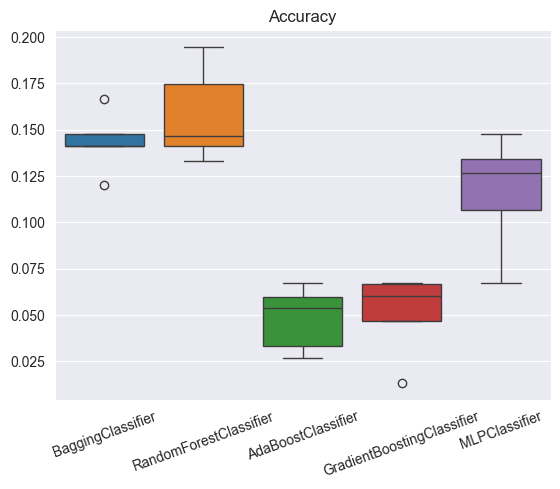

In [77]:
sns.boxplot(data=pd.DataFrame(accuracy_2)).set_title('Accuracy')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

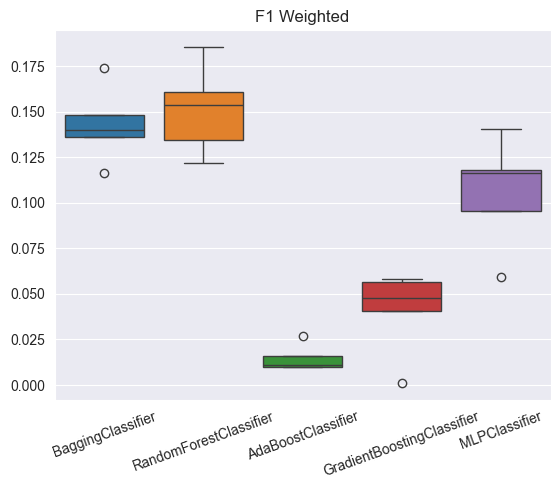

In [78]:
sns.boxplot(data=pd.DataFrame(f1_2)).set_title('F1 Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

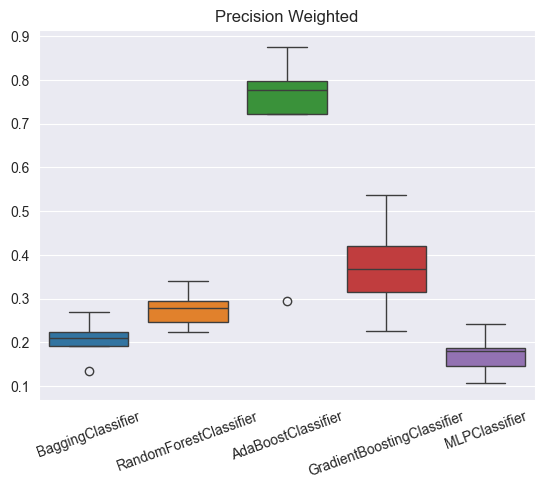

In [79]:
sns.boxplot(data=pd.DataFrame(precision_2)).set_title('Precision Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

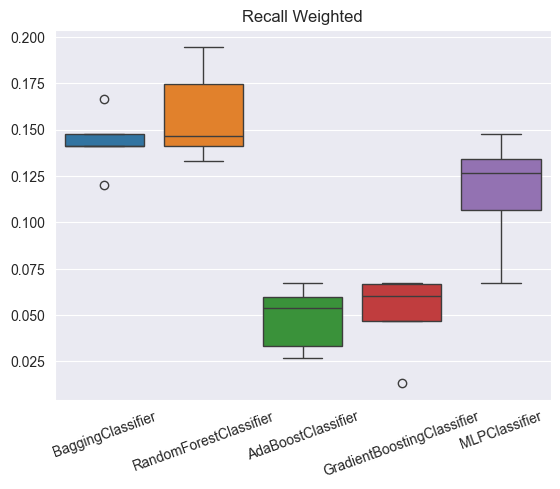

In [80]:
sns.boxplot(data=pd.DataFrame(recall_2)).set_title('Recall Weighted')
plt.xticks(rotation=20)

In [81]:
avg_accuracy_2 = {}
avg_f1_2 = {}
avg_precision_2 = {}
avg_recall_2 = {}

for i in avg_clf_results_2:
    avg_accuracy_2[i] = avg_clf_results_2[i]['Accuracy']
    avg_f1_2[i] = avg_clf_results_2[i]['F1 Weighted']
    avg_precision_2[i] = avg_clf_results_2[i]['Precision Weighted']
    avg_recall_2[i] = avg_clf_results_2[i]['Recall Weighted']

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

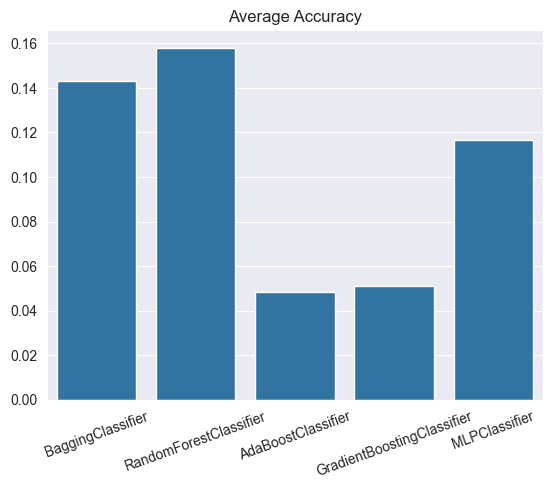

In [82]:
sns.barplot(x=list(avg_accuracy_2.keys()), y=list(avg_accuracy_2.values())).set_title('Average Accuracy')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

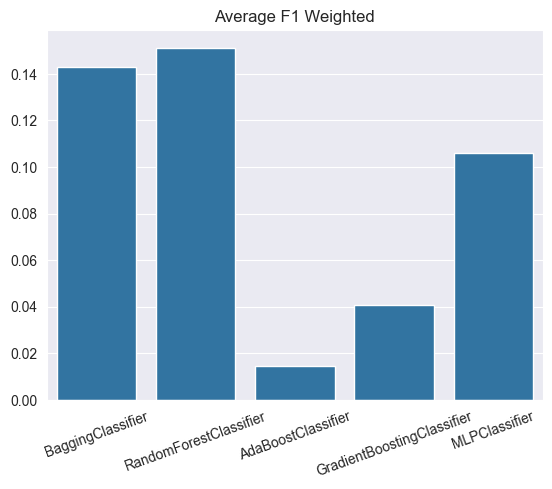

In [83]:
sns.barplot(x=list(avg_f1_2.keys()), y=list(avg_f1_2.values())).set_title('Average F1 Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

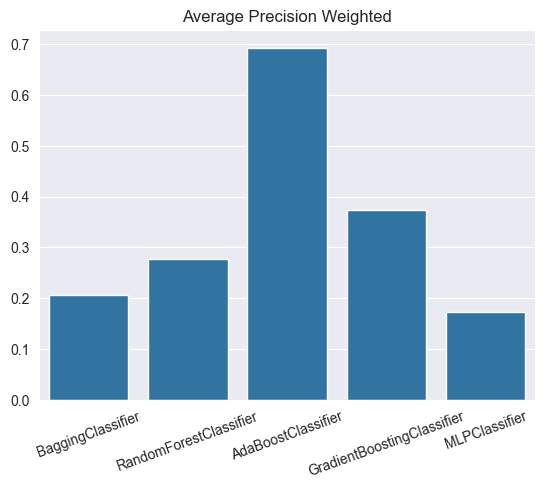

In [84]:
sns.barplot(x=list(avg_precision_2.keys()), y=list(avg_precision_2.values())).set_title('Average Precision Weighted')
plt.xticks(rotation=20)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier')])

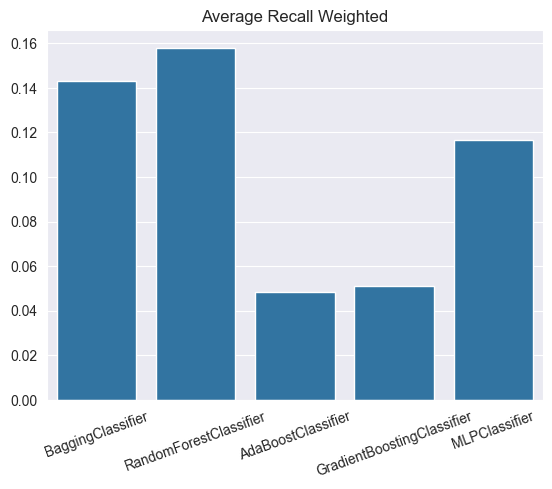

In [85]:
sns.barplot(x=list(avg_recall_2.keys()), y=list(avg_recall_2.values())).set_title('Average Recall Weighted')
plt.xticks(rotation=20)

In [86]:
#different settings of NN
MLPRegressors = [MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)]

MLPRegressors_results = {regressor.__class__.__name__: {'MAE': [], 'MSE': [], 'Explained Variance': []} for regressor in MLPRegressors}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for regressor in MLPRegressors:
        reg = regressor.__class__.__name__

        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        ev = explained_variance_score(y_test, y_pred)

        MLPRegressors_results[reg]['MAE'].append(mae)
        MLPRegressors_results[reg]['MSE'].append(mse)
        MLPRegressors_results[reg]['Explained Variance'].append(ev)
        
print(MLPRegressors_results)

{'MLPRegressor': {'MAE': [0.11461599346343886, 0.11722860144275365, 0.1096421518227979, 0.11734546073581836, 0.11575909264317547], 'MSE': [0.021820020130850968, 0.022808884440995787, 0.019983330974957476, 0.02298337885272158, 0.022369251728873493], 'Explained Variance': [0.7510251522890019, 0.7461168399564369, 0.7805876354230259, 0.7389812372651288, 0.7479957679938933]}}


In [87]:
avg_MLP_reg_results = {}
for model_name, model_scores in MLPRegressors_results.items():
    print(model_name, ':')
    avg_MLP_reg_results[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_MLP_reg_results[model_name][metric] = np.mean(scores)

MLPRegressor :
  MAE 0.11491826002159686
  MSE 0.021992973225679863
  Explained Variance 0.7529413265854974


In [88]:
maes_MLP = {}
mses_MLP = {}
evs_MLP = {}

for i in MLPRegressors_results:
    maes_MLP[i] = MLPRegressors_results[i]['MAE']
    mses_MLP[i] = MLPRegressors_results[i]['MSE']
    evs_MLP[i] = MLPRegressors_results[i]['Explained Variance']

([0], [Text(0, 0, 'MLPRegressor')])

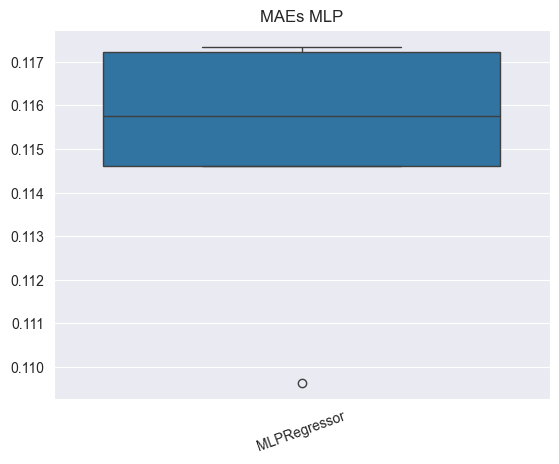

In [89]:
sns.boxplot(data=pd.DataFrame(maes_MLP)).set_title('MAEs MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPRegressor')])

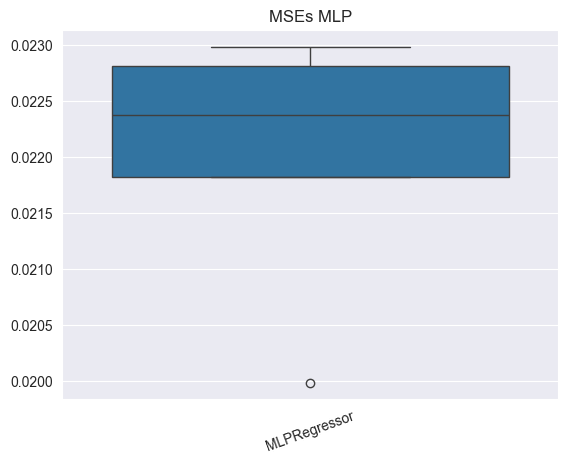

In [90]:
sns.boxplot(data=pd.DataFrame(mses_MLP)).set_title('MSEs MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPRegressor')])

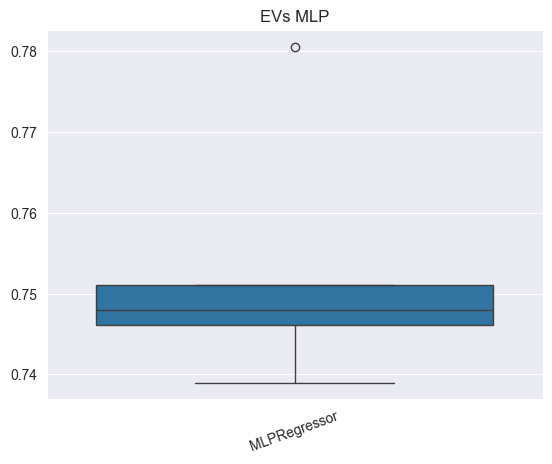

In [91]:
sns.boxplot(data=pd.DataFrame(evs_MLP)).set_title('EVs MLP')
plt.xticks(rotation=20)

In [92]:
avg_maes_MLP = {}
avg_mses_MLP = {}
avg_evs_MLP = {}

for i in avg_MLP_reg_results:
    avg_maes_MLP[i] = avg_MLP_reg_results[i]['MAE']
    avg_mses_MLP[i] = avg_MLP_reg_results[i]['MSE']
    avg_evs_MLP[i] = avg_MLP_reg_results[i]['Explained Variance']

print(avg_maes_MLP)
print(avg_mses_MLP)
print(avg_evs_MLP)

{'MLPRegressor': 0.11491826002159686}
{'MLPRegressor': 0.021992973225679863}
{'MLPRegressor': 0.7529413265854974}


([0], [Text(0, 0, 'MLPRegressor')])

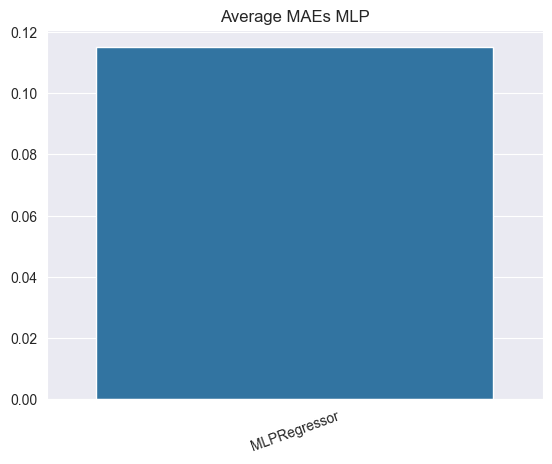

In [93]:
sns.barplot(x=list(avg_maes_MLP.keys()), y=list(avg_maes_MLP.values())).set_title('Average MAEs MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPRegressor')])

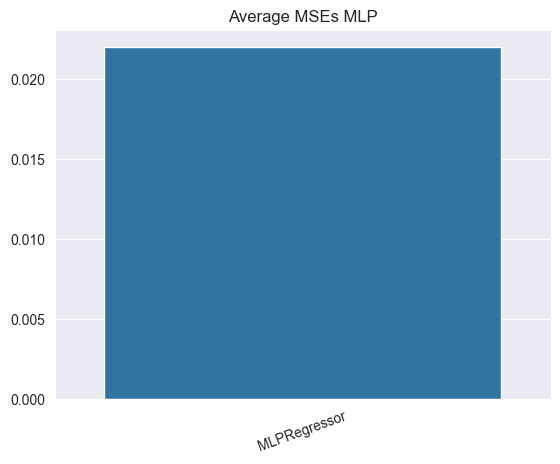

In [94]:
sns.barplot(x=list(avg_mses_MLP.keys()), y=list(avg_mses_MLP.values())).set_title('Average MSEs MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPRegressor')])

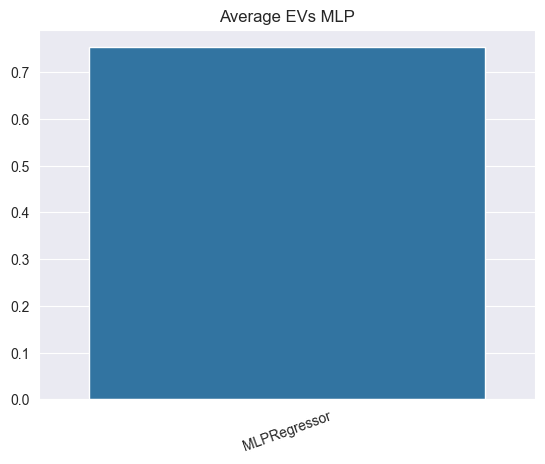

In [95]:
sns.barplot(x=list(avg_evs_MLP.keys()), y=list(avg_evs_MLP.values())).set_title('Average EVs MLP')
plt.xticks(rotation=20)

In [96]:
#different settings of NN
MLPClassifiers = [MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=42)]

MLPClassifiers_results_clf = {}
for classifier in MLPClassifiers:
    model_name = classifier.__class__.__name__
    clf_scores = {'Accuracy': [], 'F1 Weighted': [], 'Precision Weighted': [], 'Recall Weighted': []}

    for train_index, test_index in kf.split(X_clf, y_clf):
        X_train, X_test = np.array(X_clf)[train_index], np.array(X_clf)[test_index]
        y_train, y_test = np.array(y_clf)[train_index], np.array(y_clf)[test_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

        clf_scores['Accuracy'].append(accuracy)
        clf_scores['F1 Weighted'].append(f1)
        clf_scores['Precision Weighted'].append(precision)
        clf_scores['Recall Weighted'].append(recall)

    MLPClassifiers_results_clf[model_name] = clf_scores

print(MLPClassifiers_results_clf)

{'MLPClassifier': {'Accuracy': [0.14, 0.14666666666666667, 0.18120805369127516, 0.18791946308724833, 0.10738255033557047], 'F1 Weighted': [0.13996459096459096, 0.14361730861730862, 0.17263236390753167, 0.17524035380332262, 0.09924211749122921], 'Precision Weighted': [0.17353703703703705, 0.18854761904761902, 0.2437626504740599, 0.25604026845637584, 0.09722900142363228], 'Recall Weighted': [0.14, 0.14666666666666667, 0.18120805369127516, 0.18791946308724833, 0.10738255033557047]}}


In [97]:
accuracy_MLP = {}
f1_MLP = {}
precision_MLP = {}
recall_MLP = {}

for i in MLPClassifiers_results_clf:
    accuracy_MLP[i] = MLPClassifiers_results_clf[i]['Accuracy']
    f1_MLP[i] = MLPClassifiers_results_clf[i]['F1 Weighted']
    precision_MLP[i] = MLPClassifiers_results_clf[i]['Precision Weighted']
    recall_MLP[i] = MLPClassifiers_results_clf[i]['Recall Weighted']

In [98]:
avg_clf_results_MLP = {}
for model_name, model_scores in MLPClassifiers_results_clf.items():
    print(model_name, ':')
    avg_clf_results_MLP[model_name] = {}
    for metric, scores in model_scores.items():
        print(' ', metric, np.mean(scores))
        avg_clf_results_MLP[model_name][metric] = np.mean(scores)

MLPClassifier :
  Accuracy 0.15263534675615212
  F1 Weighted 0.14613934695679662
  Precision Weighted 0.19182331528774482
  Recall Weighted 0.15263534675615212


([0], [Text(0, 0, 'MLPClassifier')])

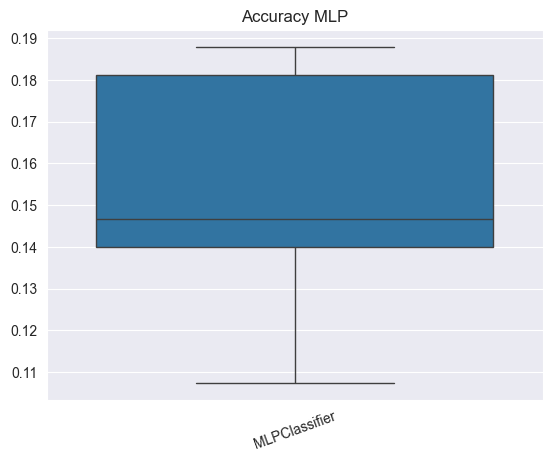

In [99]:
sns.boxplot(data=pd.DataFrame(accuracy_MLP)).set_title('Accuracy MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

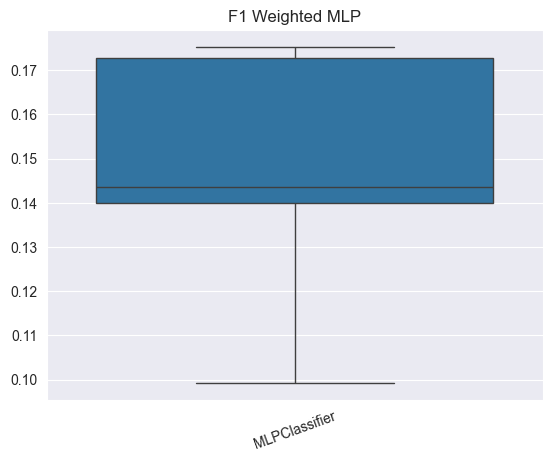

In [100]:
sns.boxplot(data=pd.DataFrame(f1_MLP)).set_title('F1 Weighted MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

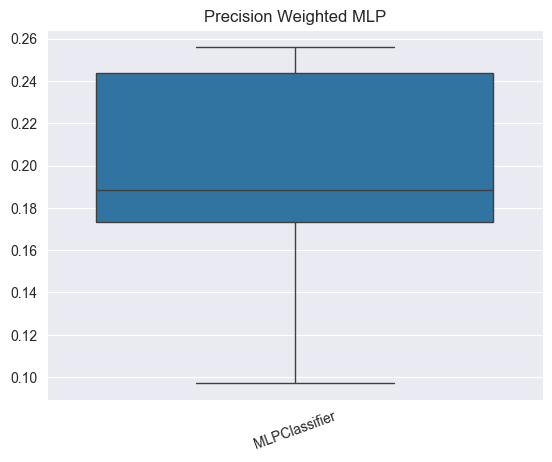

In [101]:
sns.boxplot(data=pd.DataFrame(precision_MLP)).set_title('Precision Weighted MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

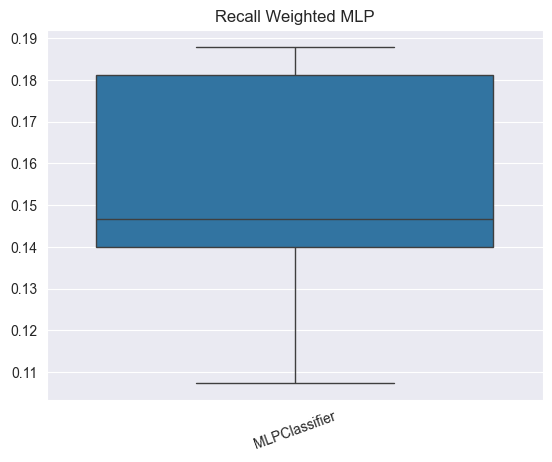

In [102]:
sns.boxplot(data=pd.DataFrame(recall_MLP)).set_title('Recall Weighted MLP')
plt.xticks(rotation=20)

In [103]:
avg_accuracy_MLP = {}
avg_f1_MLP = {}
avg_precision_MLP = {}
avg_recall_MLP = {}

for i in avg_clf_results_MLP:
    avg_accuracy_MLP[i] = avg_clf_results_MLP[i]['Accuracy']
    avg_f1_MLP[i] = avg_clf_results_MLP[i]['F1 Weighted']
    avg_precision_MLP[i] = avg_clf_results_MLP[i]['Precision Weighted']
    avg_recall_MLP[i] = avg_clf_results_MLP[i]['Recall Weighted']

([0], [Text(0, 0, 'MLPClassifier')])

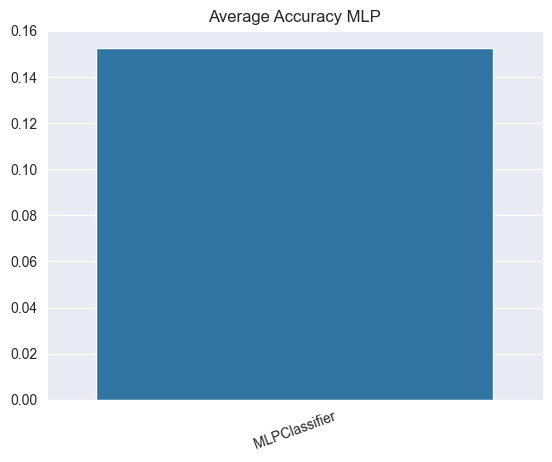

In [104]:
sns.barplot(x=list(avg_accuracy_MLP.keys()), y=list(avg_accuracy_MLP.values())).set_title('Average Accuracy MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

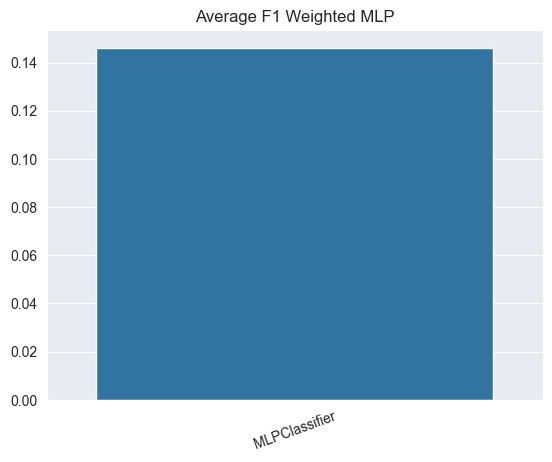

In [105]:
sns.barplot(x=list(avg_f1_MLP.keys()), y=list(avg_f1_MLP.values())).set_title('Average F1 Weighted MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

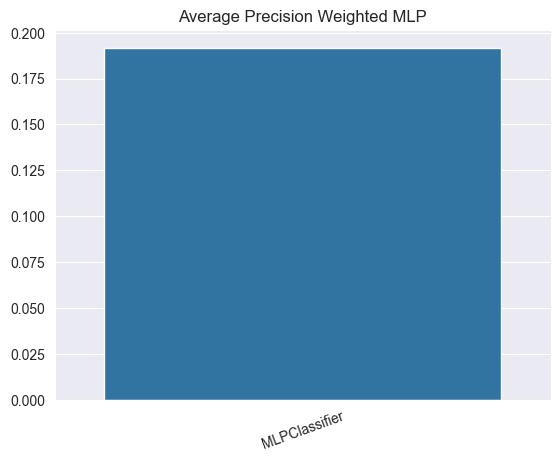

In [106]:
sns.barplot(x=list(avg_precision_MLP.keys()), y=list(avg_precision_MLP.values())).set_title('Average Precision Weighted MLP')
plt.xticks(rotation=20)

([0], [Text(0, 0, 'MLPClassifier')])

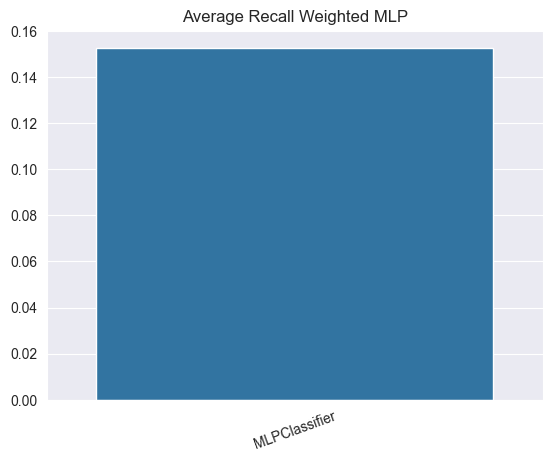

In [107]:
sns.barplot(x=list(avg_recall_MLP.keys()), y=list(avg_recall_MLP.values())).set_title('Average Recall Weighted MLP')
plt.xticks(rotation=20)

In [108]:
avg_maes_2 = {key + '_2': value for key, value in avg_maes_2.items()}
avg_maes.update(avg_maes_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor'),
  Text(5, 0, 'RandomForestRegressor_2'),
  Text(6, 0, 'BaggingRegressor_2'),
  Text(7, 0, 'AdaBoostRegressor_2'),
  Text(8, 0, 'GradientBoostingRegressor_2'),
  Text(9, 0, 'MLPRegressor_2')])

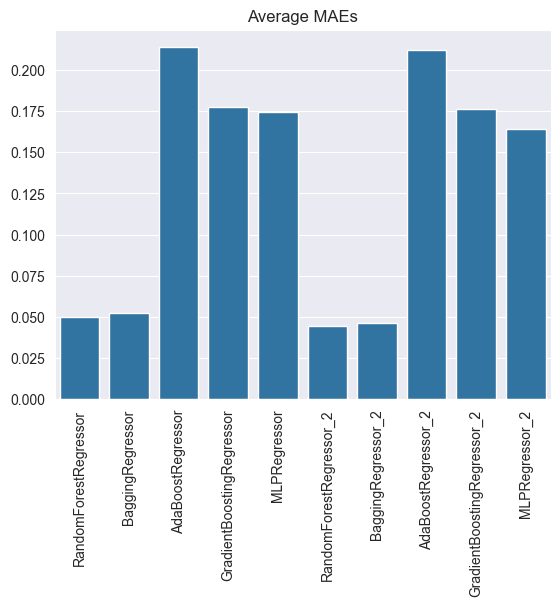

In [109]:
sns.barplot(x=list(avg_maes.keys()), y=list(avg_maes.values())).set_title('Average MAEs')
plt.xticks(rotation=90)

In [110]:
avg_mses_2 = {key + '_2': value for key, value in avg_mses_2.items()}
avg_mses.update(avg_mses_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor'),
  Text(5, 0, 'RandomForestRegressor_2'),
  Text(6, 0, 'BaggingRegressor_2'),
  Text(7, 0, 'AdaBoostRegressor_2'),
  Text(8, 0, 'GradientBoostingRegressor_2'),
  Text(9, 0, 'MLPRegressor_2')])

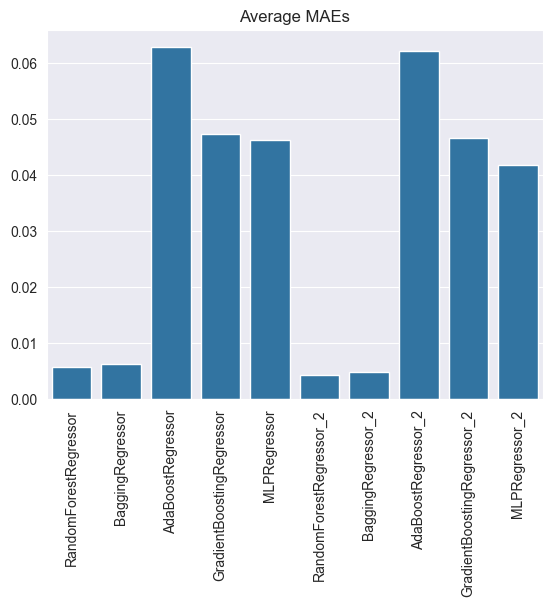

In [111]:
sns.barplot(x=list(avg_mses.keys()), y=list(avg_mses.values())).set_title('Average MAEs')
plt.xticks(rotation=90)

In [112]:
avg_evs_2 = {key + '_2': value for key, value in avg_evs_2.items()}
avg_evs.update(avg_evs_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'RandomForestRegressor'),
  Text(1, 0, 'BaggingRegressor'),
  Text(2, 0, 'AdaBoostRegressor'),
  Text(3, 0, 'GradientBoostingRegressor'),
  Text(4, 0, 'MLPRegressor'),
  Text(5, 0, 'RandomForestRegressor_2'),
  Text(6, 0, 'BaggingRegressor_2'),
  Text(7, 0, 'AdaBoostRegressor_2'),
  Text(8, 0, 'GradientBoostingRegressor_2'),
  Text(9, 0, 'MLPRegressor_2')])

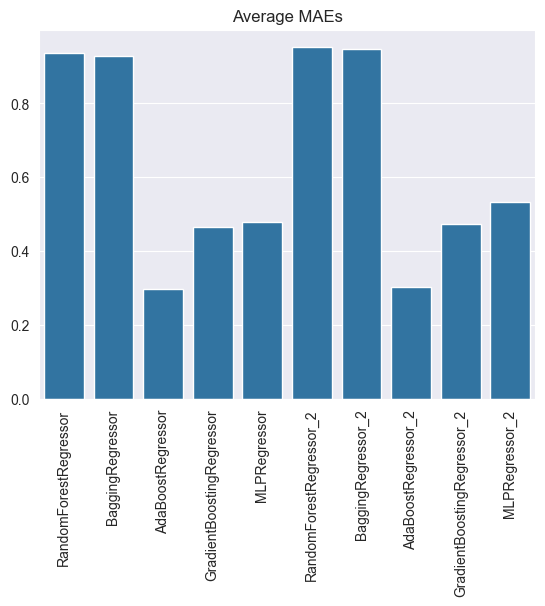

In [113]:
sns.barplot(x=list(avg_evs.keys()), y=list(avg_evs.values())).set_title('Average MAEs')
plt.xticks(rotation=90)

In [114]:
avg_accuracy_2 = {key + '_2': value for key, value in avg_accuracy_2.items()}
avg_accuracy.update(avg_accuracy_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier'),
  Text(5, 0, 'BaggingClassifier_2'),
  Text(6, 0, 'RandomForestClassifier_2'),
  Text(7, 0, 'AdaBoostClassifier_2'),
  Text(8, 0, 'GradientBoostingClassifier_2'),
  Text(9, 0, 'MLPClassifier_2')])

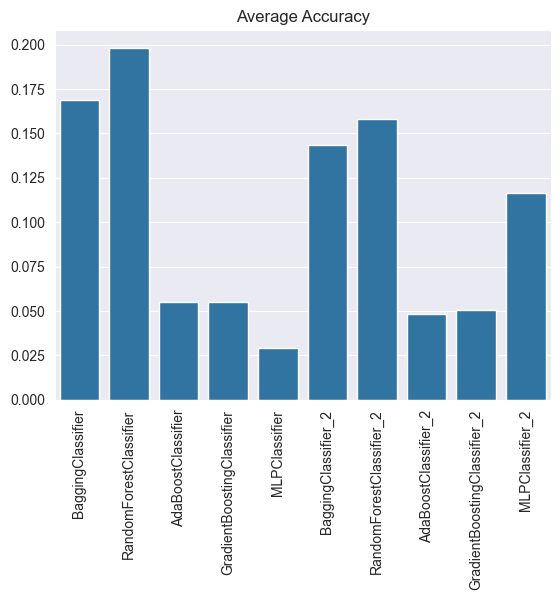

In [115]:
sns.barplot(x=list(avg_accuracy.keys()), y=list(avg_accuracy.values())).set_title('Average Accuracy')
plt.xticks(rotation=90)

In [116]:
avg_f1_2 = {key + '_2': value for key, value in avg_f1_2.items()}
avg_f1.update(avg_f1_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier'),
  Text(5, 0, 'BaggingClassifier_2'),
  Text(6, 0, 'RandomForestClassifier_2'),
  Text(7, 0, 'AdaBoostClassifier_2'),
  Text(8, 0, 'GradientBoostingClassifier_2'),
  Text(9, 0, 'MLPClassifier_2')])

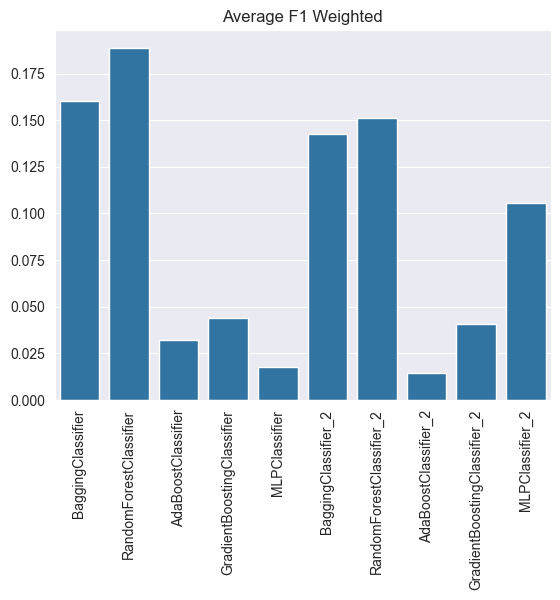

In [117]:
sns.barplot(x=list(avg_f1.keys()), y=list(avg_f1.values())).set_title('Average F1 Weighted')
plt.xticks(rotation=90)

In [118]:
avg_precision_2 = {key + '_2': value for key, value in avg_precision_2.items()}
avg_precision.update(avg_precision_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier'),
  Text(5, 0, 'BaggingClassifier_2'),
  Text(6, 0, 'RandomForestClassifier_2'),
  Text(7, 0, 'AdaBoostClassifier_2'),
  Text(8, 0, 'GradientBoostingClassifier_2'),
  Text(9, 0, 'MLPClassifier_2')])

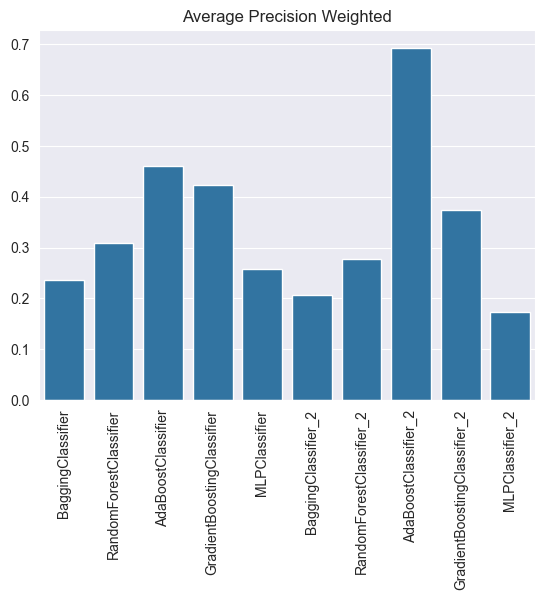

In [119]:
sns.barplot(x=list(avg_precision.keys()), y=list(avg_precision.values())).set_title('Average Precision Weighted')
plt.xticks(rotation=90)

In [120]:
avg_recall_2 = {key + '_2': value for key, value in avg_recall_2.items()}
avg_recall.update(avg_recall_2)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'BaggingClassifier'),
  Text(1, 0, 'RandomForestClassifier'),
  Text(2, 0, 'AdaBoostClassifier'),
  Text(3, 0, 'GradientBoostingClassifier'),
  Text(4, 0, 'MLPClassifier'),
  Text(5, 0, 'BaggingClassifier_2'),
  Text(6, 0, 'RandomForestClassifier_2'),
  Text(7, 0, 'AdaBoostClassifier_2'),
  Text(8, 0, 'GradientBoostingClassifier_2'),
  Text(9, 0, 'MLPClassifier_2')])

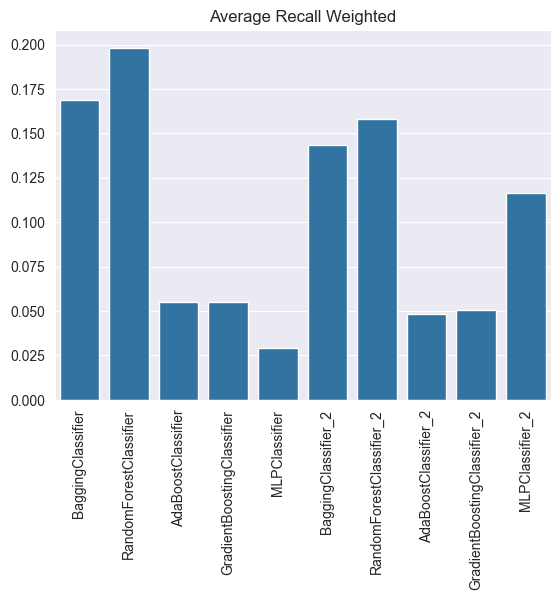

In [121]:
sns.barplot(x=list(avg_recall.keys()), y=list(avg_recall.values())).set_title('Average Recall Weighted')
plt.xticks(rotation=90)